In [1]:
import sys
sys.path.append('/home/kevinteng/Desktop/BrainTumourSegmentation')
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import os 
import utils
from utils_vis import plot_comparison, plot_labels_color 
from utils import dice_coef, ss_metric, compute_metric
from sklearn.metrics import confusion_matrix
%matplotlib inline

/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-package

- Blue => Label 1 (Necrotic and Non-enhancing Tumor Core)
- Yellow => Label 2 (Peritumoral Edema)
- Brown => Label 3/4 (GD-Enhancing Tumor)
---
* Core => Label 1 & 3
* Enhancing => Label 3
* Complete => Label 1,2, 3

---

# Hyperparameter

In [2]:
SHUFFLE_BUFFER = 4000
BATCH_SIZE = 16
lr = 0.000001
opt = tf.keras.optimizers.Adam(lr)
ver = 'AttUnet_02' #save version 
dropout=0.2 #dropout rate
hn = 'he_normal' #kernel initializer 
tfrecords_read_dir = '/home/kevinteng/Desktop/ssd02/BraTS20_tfrecords03/HGG/'

---

# Helper Functions

In [3]:
xent = tf.keras.losses.CategoricalCrossentropy()

def generalized_dice(y_true, y_pred, smooth = 1e-5):
    """
    Generalized Dice Score
    https://arxiv.org/pdf/1707.03237
    https://github.com/Mehrdad-Noori/Brain-Tumor-Segmentation/blob/master/loss.py
    """
    
    y_true    = tf.reshape(y_true,shape=(-1,4))
    y_pred    = tf.reshape(y_pred,shape=(-1,4))
    sum_p     = tf.reduce_sum(y_pred, -2)
    sum_r     = tf.reduce_sum(y_true, -2)
    sum_pr    = tf.reduce_sum(y_true * y_pred, -2)
    weights   = tf.math.pow(tf.math.square(sum_r) + smooth, -1)
    generalized_dice = (2 * tf.reduce_sum(weights * sum_pr)) / (tf.reduce_sum(weights * (sum_r + sum_p)))
    return generalized_dice

def generalized_dice_loss(y_true, y_pred):   
    return 1-generalized_dice(y_true, y_pred)
    
def custom_loss(y_true, y_pred):
    
    """
    The final loss function consists of the summation of two losses "GDL" and "CE"
    with a regularization term.
    """
    
    return generalized_dice_loss(y_true, y_pred) + 1.25 * xent(y_true, y_pred)

----

# Model

In [4]:
from utils_model import conv_block, coordconv_block, up, pool, attention_block
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Activation, Add, Multiply

def AttUnet_model(input_layer, attention_mode='grid'):
    #downsampling path
    conv1 = conv_block(input_layer, filters=64, kernel_initializer=hn)
    pool1 = pool(conv1)
    
    conv2 = conv_block(pool1, filters=128, kernel_initializer=hn)
    pool2 = pool(conv2)
    
    conv3 = conv_block(pool2, filters=256, kernel_initializer=hn)
    pool3 = pool(conv3)
    
    conv4 = conv_block(pool3, filters=512, kernel_initializer=hn, dropout_rate = dropout)
    pool4 = pool(conv4)
    
    conv5 = conv_block(pool4, filters=1024, kernel_initializer=hn, dropout_rate = dropout)
    
    #upsampling path
    att01 = attention_block(conv4, conv5, 512)
    up1 = up(conv5,filters=512, merge=att01, kernel_initializer=hn)
    conv6 = conv_block(up1, filters=512, kernel_initializer=hn)
    
    if attention_mode=='grid':
        att02 = attention_block(conv3, conv6, 256)
    else:
        att02 = attention_block(conv3, conv4, 256)
    up2 = up(conv6, filters=256, merge=att02, kernel_initializer=hn)
    conv7 = conv_block(up2, filters=256, kernel_initializer=hn)
    
    if attention_mode=='grid':
        att03 = attention_block(conv2, conv7, 128)
    else:
        att03 = attention_block(conv2, conv3, 128)
    up3 = up(conv7, filters=128, merge=att03, kernel_initializer=hn)
    conv8 = conv_block(up3, filters=128, kernel_initializer=hn)
    
    if attention_mode=='grid':
        att04 = attention_block(conv1, conv8, 64)
    else:
        att04 = attention_block(conv1, conv2, 64)
    up4 = up(conv8, filters=64, merge=att04, kernel_initializer=hn)
    conv9 = conv_block(up4, filters=64, kernel_initializer=hn)
    
    output_layer = Conv2D(4, (1,1), activation = 'softmax')(conv9)
    
    return output_layer

In [5]:
input_layer = Input(shape=(240,240,4))
model = Model(input_layer, AttUnet_model(input_layer))

In [6]:

@tf.function
def train_fn(image, label):
    with tf.GradientTape() as tape:
        model_output = model(image)
        loss = generalized_dice_loss(label, model_output)
    gradients = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    
    return model_output, loss, gradients


Epochs  1



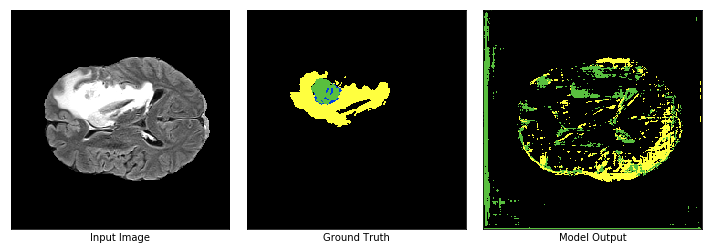

Steps: 1, Loss:0.9958937168121338
Accurary: 0.8305208086967468
Dice coefficient: [0.03425391, 0.029353783, 0.12890515]
Sensitivity: [0.11904763215702929, 0.1181658003850829, 0.19634181424309283]
Specificity: [0.9311586565607155, 0.9310749916835735, 0.8803534130828722]
Gradient min:-0.0009747778531163931, max:0.0009446253534406424



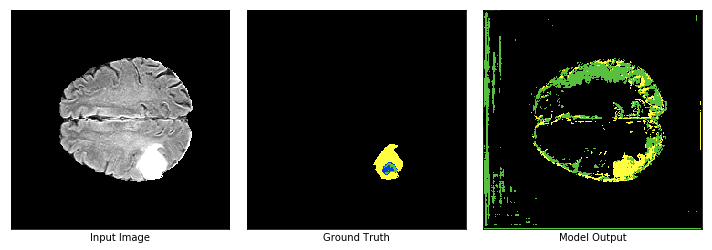

Steps: 2, Loss:0.995060384273529
Accurary: 0.87109375
Dice coefficient: [0.001376938, 0.00035044856, 0.1354668]
Sensitivity: [0.02500006093749619, 0.01724154875145711, 0.6774969954573166]
Specificity: [0.9017061281508172, 0.9018456084422082, 0.878137716028442]
Gradient min:-0.0007803920307196677, max:0.000497853965498507



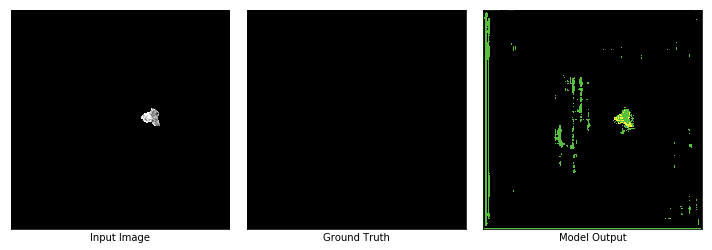

Steps: 3, Loss:0.9988722205162048
Accurary: 0.9585242867469788
Dice coefficient: [4.3252593e-09, 4.3290043e-09, 4.1858517e-09]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9598611111180797, 0.9598958333402958, 0.9585243055627563]
Gradient min:-0.00043758979882113636, max:0.00029940149397589266



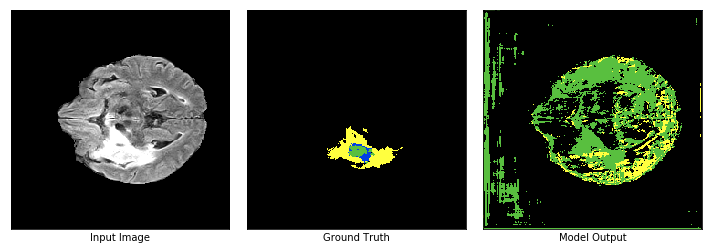

Steps: 4, Loss:0.9978563189506531
Accurary: 0.7653124928474426
Dice coefficient: [0.039865967, 0.020553911, 0.1839551]
Sensitivity: [0.6304347926512285, 0.556603794499821, 0.8572307701093491]
Specificity: [0.8071183953370286, 0.8056736600324679, 0.7833497097305315]
Gradient min:-0.0004533690807875246, max:0.00029844287200830877



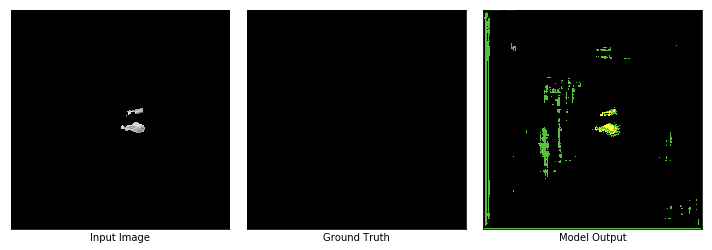

Steps: 5, Loss:0.9986138343811035
Accurary: 0.9545833468437195
Dice coefficient: [4.032258e-09, 4.0355124e-09, 3.8226298e-09]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9569444444519194, 0.9569791666741355, 0.9545833333412181]
Gradient min:-0.0003356189699843526, max:0.00022831937531009316



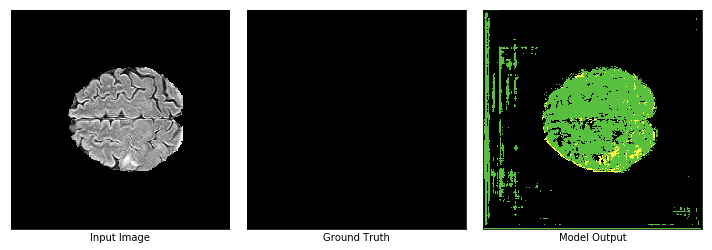

Steps: 6, Loss:0.9962692856788635
Accurary: 0.7720659971237183
Dice coefficient: [8.01796e-10, 8.018603e-10, 7.616726e-10]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.7834722222598138, 0.783489583370922, 0.7720659722617941]
Gradient min:-0.000896979181561619, max:0.0006909428630024195



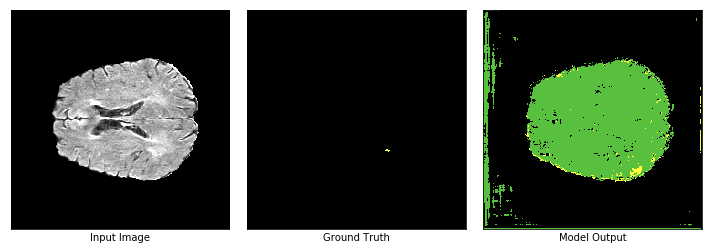

Steps: 7, Loss:1.0
Accurary: 0.6773263812065125
Dice coefficient: [5.516024e-10, 5.516328e-10, 0.0007529721]
Sensitivity: [1.0, 1.0, 0.6363639669418483]
Specificity: [0.685260416721309, 0.6852777778324171, 0.6774557641776284]
Gradient min:-7.066718304277186e-12, max:6.6636349216331325e-12



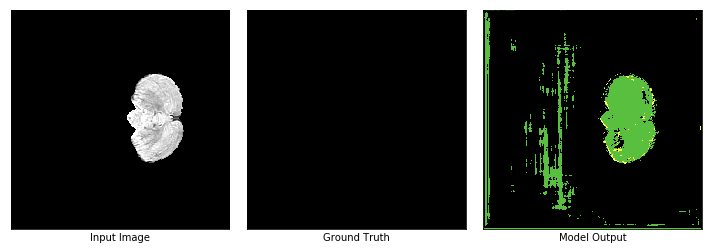

Steps: 8, Loss:0.9938341975212097
Accurary: 0.8623090386390686
Dice coefficient: [1.2953367e-09, 1.2956725e-09, 1.260875e-09]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.865972222245491, 0.8660069444677071, 0.8623090278016825]
Gradient min:-0.0006925502675585449, max:0.00042434889473952353



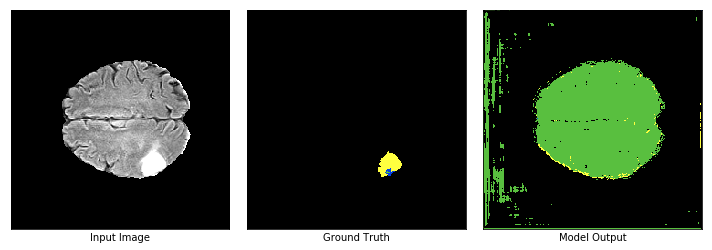

Steps: 9, Loss:0.9909592866897583
Accurary: 0.7067534923553467
Dice coefficient: [0.0057540163, 0.0012019959, 0.05308308]
Sensitivity: [0.905660395158416, 1.0, 1.0]
Specificity: [0.7118355431713494, 0.7114255947714142, 0.7121580707201459]
Gradient min:-0.0010857881279662251, max:0.000812219746876508



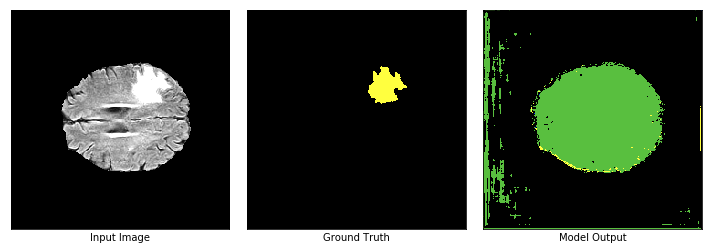

Steps: 10, Loss:0.9989368915557861
Accurary: 0.7265625
Dice coefficient: [6.436249e-10, 6.438321e-10, 0.12321258]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.7302604167134965, 0.7303472222690369, 0.7398437224233915]
Gradient min:-0.00015432208601851016, max:8.648281800560653e-05



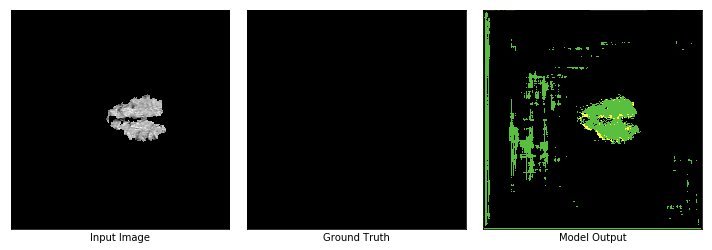

Steps: 11, Loss:0.9974408745765686
Accurary: 0.899218738079071
Dice coefficient: [1.7882689e-09, 1.7885887e-09, 1.7226528e-09]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9029166666835214, 0.9029340277946295, 0.8992187500174967]
Gradient min:-0.0003581098571885377, max:0.00019402366888243705



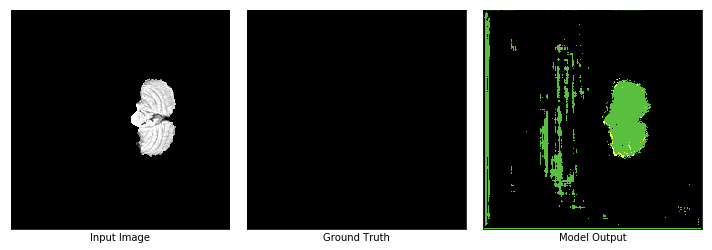

Steps: 12, Loss:0.9985466599464417
Accurary: 0.8880555629730225
Dice coefficient: [1.5822784e-09, 1.5832805e-09, 1.5508684e-09]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.8902777777968268, 0.8903472222412592, 0.8880555555749904]
Gradient min:-0.00019726739265024662, max:0.00013415090506896377



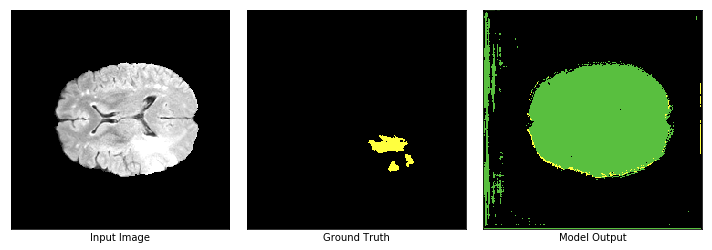

Steps: 13, Loss:0.998054563999176
Accurary: 0.6860416531562805
Dice coefficient: [5.628412e-10, 5.628729e-10, 0.07420024]
Sensitivity: [1.0, 1.0, 0.9985673352640783]
Specificity: [0.6915451389424401, 0.6915625000535482, 0.6943516924371109]
Gradient min:-0.00019356700067874044, max:0.0001023535878630355



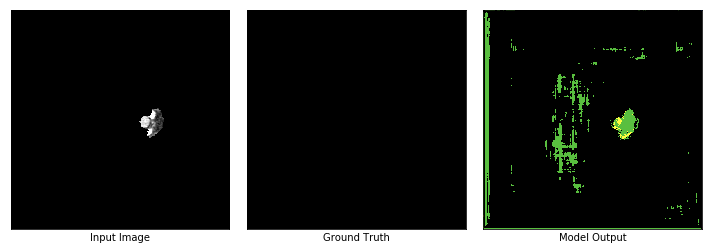

Steps: 14, Loss:0.9958441853523254
Accurary: 0.9358159899711609
Dice coefficient: [2.7793219e-09, 2.7800944e-09, 2.7048959e-09]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9375347222330669, 0.937552083344175, 0.9358159722333653]
Gradient min:-0.0005155952530913055, max:0.00036929803900420666



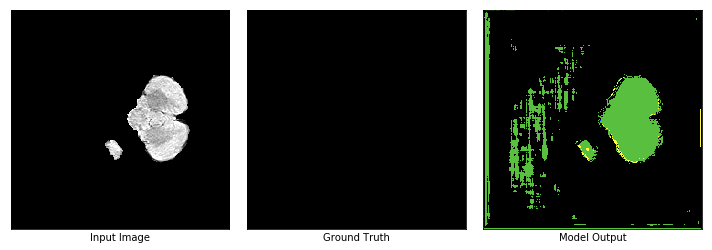

Steps: 15, Loss:0.9966313242912292
Accurary: 0.8441492915153503
Dice coefficient: [1.1401208e-09, 1.1403809e-09, 1.1139578e-09]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.847725694470881, 0.8477604166930972, 0.844149305582613]
Gradient min:-0.00034389112261123955, max:0.00035550384200178087



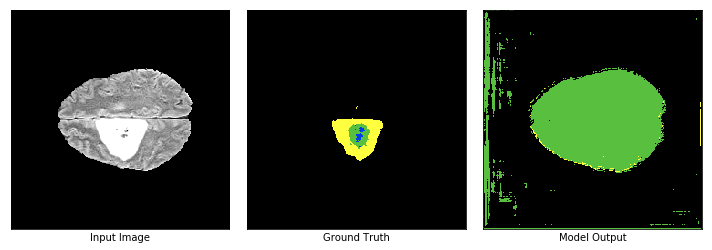

Steps: 16, Loss:0.9940363168716431
Accurary: 0.7473784685134888
Dice coefficient: [0.061024528, 0.051288832, 0.21164781]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.7500875105450001, 0.7491085786637229, 0.7640958590478407]
Gradient min:-0.0005395697080530226, max:0.00027088134083896875



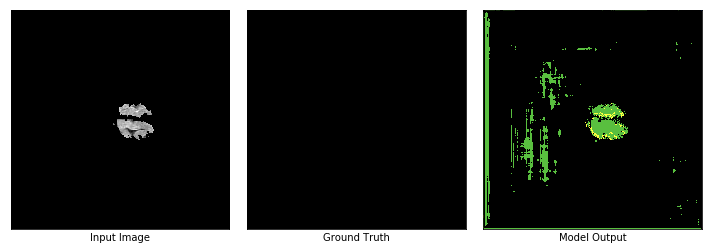

Steps: 17, Loss:0.9925447106361389
Accurary: 0.9268749952316284
Dice coefficient: [2.4654832e-09, 2.466091e-09, 2.374169e-09]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9295833333455584, 0.9296006944566666, 0.9268750000126953]
Gradient min:-0.0008543550502508879, max:0.0005083663272671402



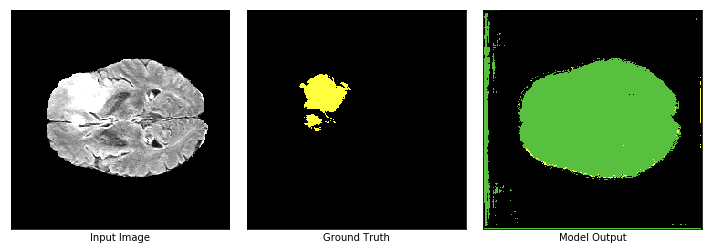

Steps: 18, Loss:0.9976797699928284
Accurary: 0.6549652814865112
Dice coefficient: [5.077688e-10, 5.0779464e-10, 0.15751171]
Sensitivity: [1.0, 1.0, 0.9994117647093426]
Specificity: [0.6580902778371371, 0.6581076389482452, 0.6748837209883929]
Gradient min:-0.0002756218600552529, max:0.00019861913460772485



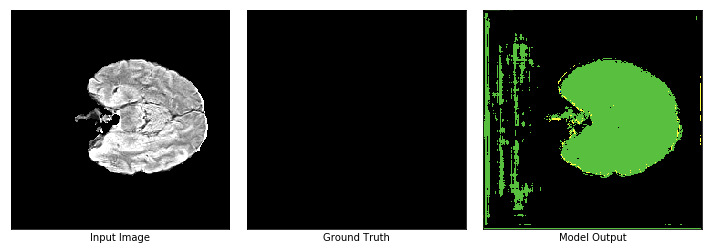

Steps: 19, Loss:0.997891366481781
Accurary: 0.7049826383590698
Dice coefficient: [5.9891e-10, 5.990176e-10, 5.884776e-10]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.7101215278281039, 0.7101736111614282, 0.7049826389401072]
Gradient min:-0.00021730105800088495, max:0.0002577353152446449



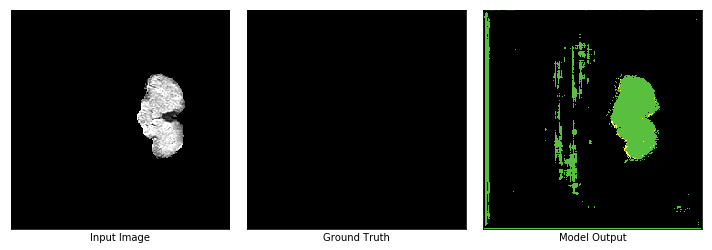

Steps: 20, Loss:0.9956375360488892
Accurary: 0.8855208158493042
Dice coefficient: [1.5358623e-09, 1.5363343e-09, 1.5165301e-09]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.8869618055751802, 0.8869965277973965, 0.8855208333532082]
Gradient min:-0.00046721010585315526, max:0.00022455987345892936



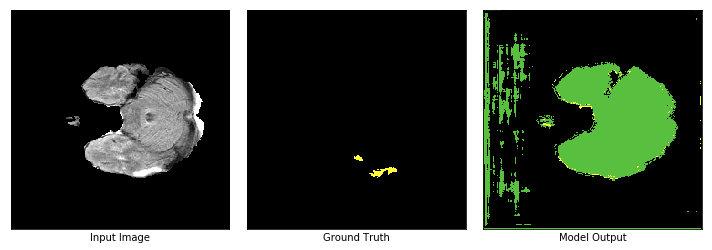

Steps: 21, Loss:0.995843231678009
Accurary: 0.7292013764381409
Dice coefficient: [6.493085e-10, 6.493928e-10, 0.023437005]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.7326215278241976, 0.7326562500464139, 0.731481320259256]
Gradient min:-0.00042234649299643934, max:0.00031125632813200355



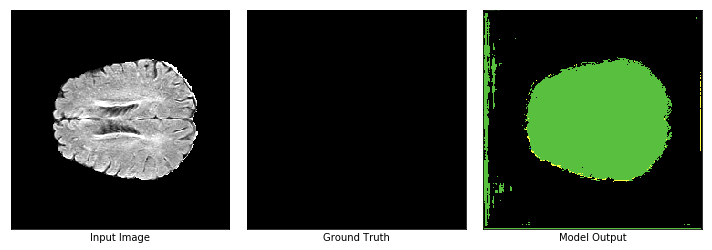

Steps: 22, Loss:0.9930278062820435
Accurary: 0.6729340553283691
Dice coefficient: [5.369992e-10, 5.370569e-10, 5.308137e-10]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.6767013889450172, 0.6767361111672333, 0.6729340278345601]
Gradient min:-0.0008296287851408124, max:0.0006523505435325205



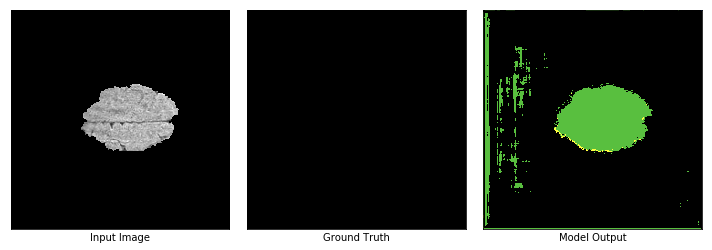

Steps: 23, Loss:0.9988569617271423
Accurary: 0.8546006679534912
Dice coefficient: [1.2116805e-09, 1.2118274e-09, 1.1940299e-09]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.8567187500248752, 0.8567361111359834, 0.8546006944696873]
Gradient min:-0.00010150748857995495, max:7.901773642515764e-05



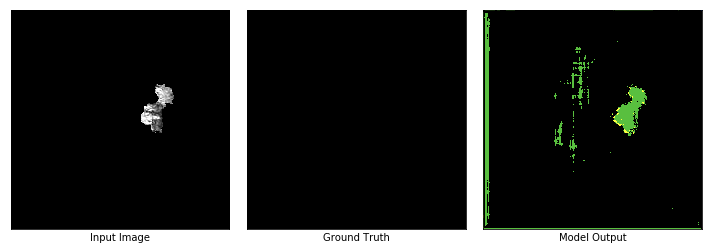

Steps: 24, Loss:0.9947862029075623
Accurary: 0.945555567741394
Dice coefficient: [3.2722511e-09, 3.2733223e-09, 3.1887755e-09]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9469444444536554, 0.9469618055647636, 0.9455555555650077]
Gradient min:-0.0007263222360052168, max:0.0003883836034219712



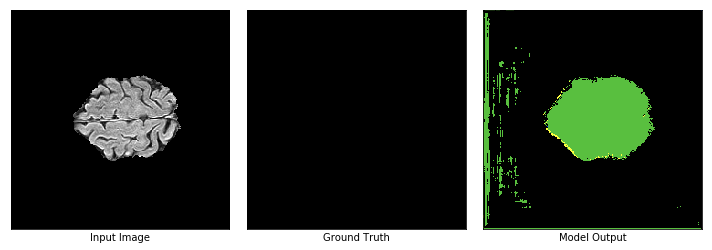

Steps: 25, Loss:0.989486813545227
Accurary: 0.8185069561004639
Dice coefficient: [9.683354e-10, 9.685229e-10, 9.565716e-10]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.820711805586682, 0.8207465278088982, 0.8185069444759536]
Gradient min:-0.0005698680761270225, max:0.0004936502082273364



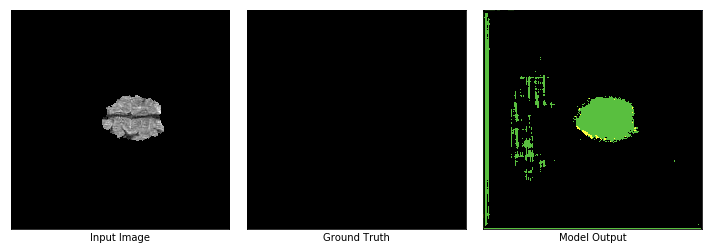

Steps: 26, Loss:0.9935059547424316
Accurary: 0.9134374856948853
Dice coefficient: [2.0433184e-09, 2.0437358e-09, 2.0056157e-09]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9150347222369731, 0.9150520833480812, 0.9134375000150282]
Gradient min:-0.0004230051417835057, max:0.00033086229814216495



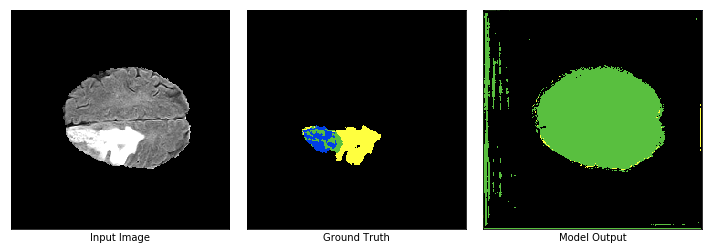

Steps: 27, Loss:0.9976810812950134
Accurary: 0.7566493153572083
Dice coefficient: [0.11775565, 0.053792067, 0.27111325]
Sensitivity: [0.965405405779401, 0.9656862753508266, 0.9903593339598626]
Specificity: [0.7644640494460584, 0.7578857183246108, 0.7807223688888386]
Gradient min:-0.00020245768246240914, max:0.00014909447054378688



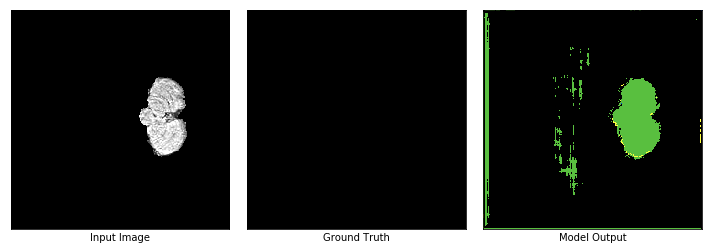

Steps: 28, Loss:0.9955372214317322
Accurary: 0.9044444561004639
Dice coefficient: [1.8446781e-09, 1.8453589e-09, 1.8168604e-09]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.905885416683006, 0.9059201389052222, 0.904444444461034]
Gradient min:-0.0002760639472398907, max:0.000250427721766755



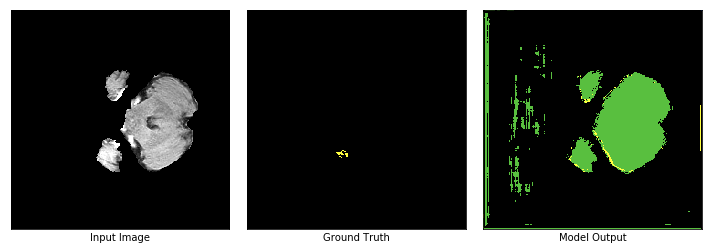

Steps: 29, Loss:0.993306577205658
Accurary: 0.8246874809265137
Dice coefficient: [1.0122482e-09, 1.0123506e-09, 0.007694585]
Sensitivity: [1.0, 1.0, 0.9750000062499984]
Specificity: [0.8284895833631094, 0.8285069444742176, 0.8252605976676058]
Gradient min:-0.0003753298078663647, max:0.000295713369268924



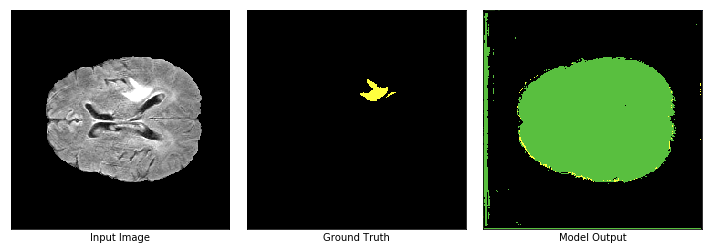

Steps: 30, Loss:0.9876563549041748
Accurary: 0.6422395706176758
Dice coefficient: [4.9031623e-10, 4.9034027e-10, 0.03452716]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.6459201389503612, 0.6459375000614692, 0.6463014082172156]
Gradient min:-0.0006288511794991791, max:0.00045495855738408864



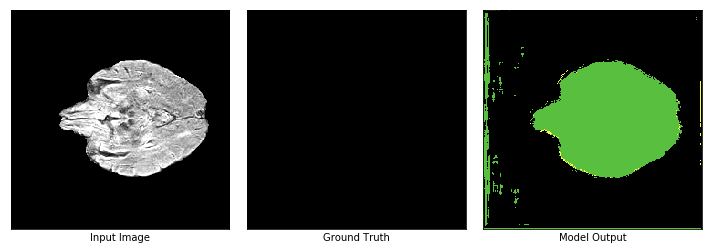

Steps: 31, Loss:0.9968917369842529
Accurary: 0.7175694704055786
Dice coefficient: [6.2165856e-10, 6.216972e-10, 6.147037e-10]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.7207291667151512, 0.7207465278262593, 0.7175694444934776]
Gradient min:-0.0001378303422825411, max:0.0001216078526340425



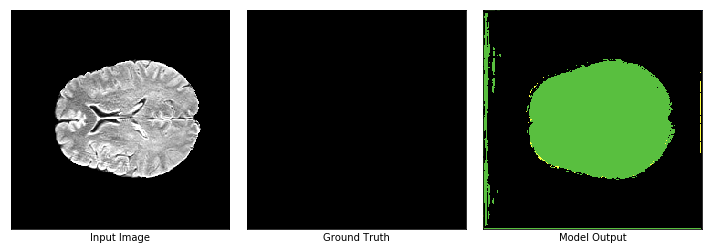

Steps: 32, Loss:0.99365234375
Accurary: 0.6874826550483704
Dice coefficient: [5.6044386e-10, 5.604753e-10, 5.555247e-10]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.6902256944982247, 0.6902430556093329, 0.6874826389431454]
Gradient min:-0.00015871111827436835, max:0.0001927142293425277



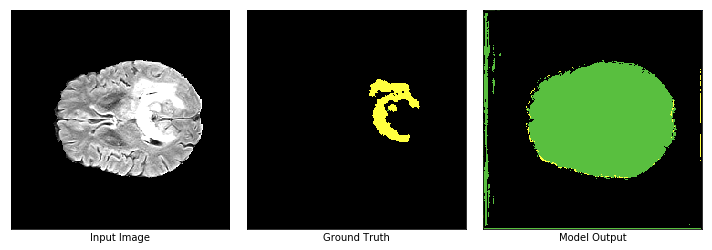

Steps: 33, Loss:0.9967927932739258
Accurary: 0.6881250143051147
Dice coefficient: [0.00045149328, 0.00045151878, 0.16493897]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.6924960067205195, 0.6925133690373441, 0.7079039028832895]
Gradient min:-0.00010195028880843893, max:0.00010121650848304853



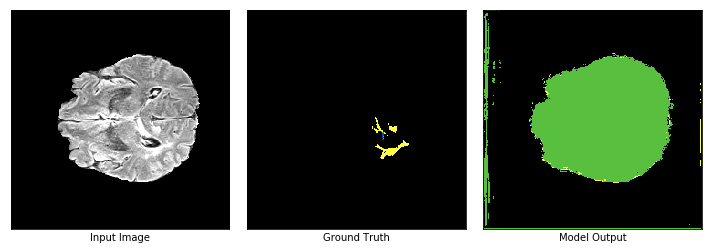

Steps: 34, Loss:0.9932272434234619
Accurary: 0.6895833611488342
Dice coefficient: [0.00203298, 0.0007911845, 0.037845545]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.6930985377907856, 0.6930008855775874, 0.6936162781078306]
Gradient min:-0.0003482514002826065, max:0.00022080341295804828



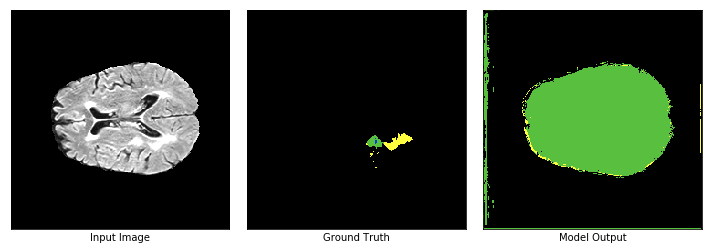

Steps: 35, Loss:0.996225118637085
Accurary: 0.7045139074325562
Dice coefficient: [0.018915584, 0.01798519, 0.050627165]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.7092393670312437, 0.7091580065609766, 0.7073345698101035]
Gradient min:-0.00020256511925254017, max:0.00011580847785808146



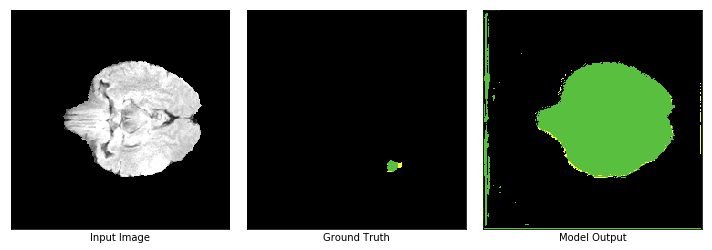

Steps: 36, Loss:0.9991883635520935
Accurary: 0.7415624856948853
Dice coefficient: [0.014812821, 0.014813818, 0.018237082]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.7454861715523593, 0.7455035658818049, 0.7414291184188805]
Gradient min:-4.43397912022192e-05, max:2.424285230517853e-05



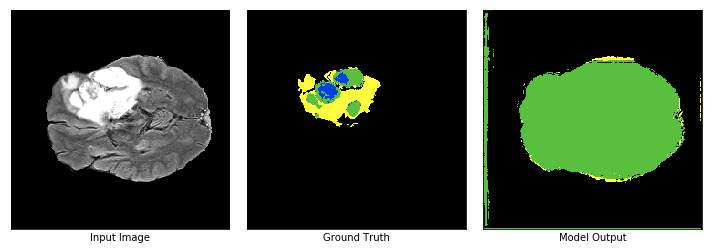

Steps: 37, Loss:0.995517373085022
Accurary: 0.6622396111488342
Dice coefficient: [0.13231458, 0.09676194, 0.29674307]
Sensitivity: [1.0, 1.0, 0.9949790795119133]
Specificity: [0.6684941260825037, 0.663774058488932, 0.6873275942446861]
Gradient min:-0.00027976222918368876, max:0.00015807517047505826



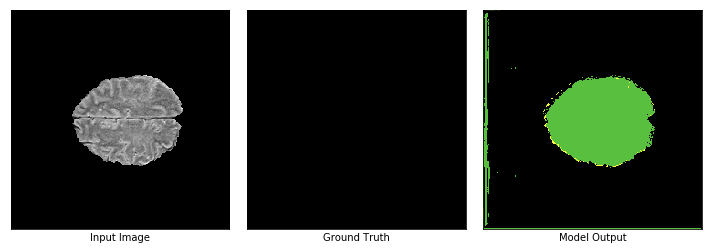

Steps: 38, Loss:0.9943592548370361
Accurary: 0.8210590481758118
Dice coefficient: [9.82801e-10, 9.828975e-10, 9.702144e-10]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.8233506944751128, 0.8233680555862208, 0.8210590278088439]
Gradient min:-0.0003265984996687621, max:0.00015443694428540766



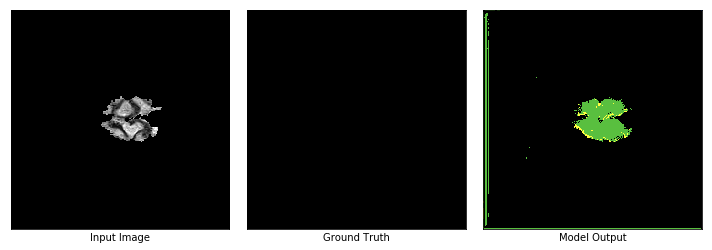

Steps: 39, Loss:0.9934267997741699
Accurary: 0.9449305534362793
Dice coefficient: [3.3411292e-09, 3.3422458e-09, 3.152585e-09]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9480381944534656, 0.9480555555645737, 0.9449305555651162]
Gradient min:-0.0004759770818054676, max:0.00027073262026533484



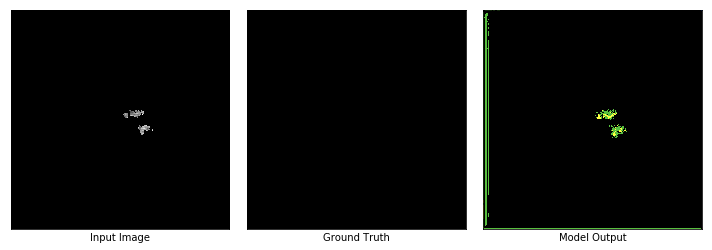

Steps: 40, Loss:0.9943255186080933
Accurary: 0.9754514098167419
Dice coefficient: [7.581501e-09, 7.5872535e-09, 7.0721358e-09]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9771006944484201, 0.9771180555595281, 0.9754513888931508]
Gradient min:-0.0002832766331266612, max:0.00017002214735839516



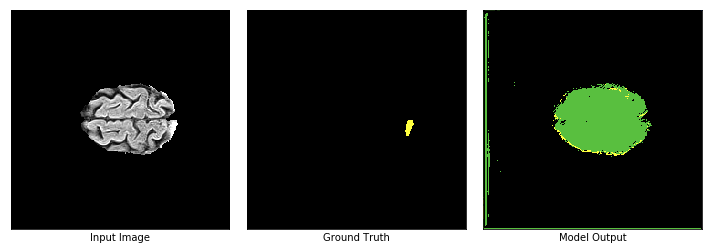

Steps: 41, Loss:0.997238039970398
Accurary: 0.8718576431274414
Dice coefficient: [1.4031148e-09, 1.4033118e-09, 0.024086714]
Sensitivity: [1.0, 1.0, 0.8256880893864138]
Specificity: [0.8762673611325925, 0.8762847222437006, 0.8734758484156693]
Gradient min:-0.00010315924737369642, max:6.784473225707188e-05



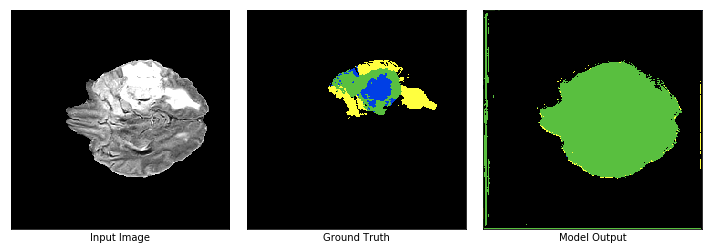

Steps: 42, Loss:0.9887980222702026
Accurary: 0.7641839981079102
Dice coefficient: [0.2762038, 0.18601795, 0.41299206]
Sensitivity: [0.9805463576964141, 0.9818417640606889, 0.9725247525432555]
Specificity: [0.7758589446622465, 0.7641371437146995, 0.7935399552289881]
Gradient min:-0.0004286817566026002, max:0.00034455416607670486



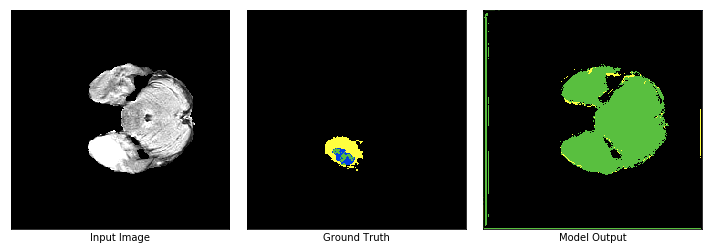

Steps: 43, Loss:0.9989196062088013
Accurary: 0.8213194608688354
Dice coefficient: [0.056966897, 0.023107804, 0.17390543]
Sensitivity: [1.0, 1.0, 0.9880597016113463]
Specificity: [0.8289822700284479, 0.8264326224163334, 0.8335188621197069]
Gradient min:-5.08102893945761e-05, max:2.2448999516200274e-05



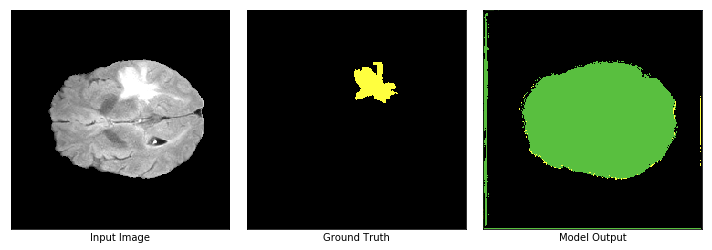

Steps: 44, Loss:0.9997075200080872
Accurary: 0.6832812428474426
Dice coefficient: [5.5435445e-10, 5.5438515e-10, 0.12334122]
Sensitivity: [1.0, 1.0, 0.9966749792462595]
Specificity: [0.6868229167210377, 0.6868402778321459, 0.6978562690040505]
Gradient min:-1.689518103376031e-05, max:9.862062142929062e-06



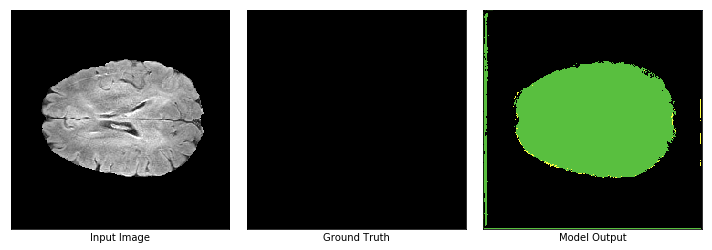

Steps: 45, Loss:0.9972795248031616
Accurary: 0.6696180701255798
Dice coefficient: [5.301384e-10, 5.3016647e-10, 5.2548604e-10]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.6725173611679658, 0.6725347222790738, 0.6696180556129135]
Gradient min:-8.855646592564881e-05, max:7.592157635372132e-05



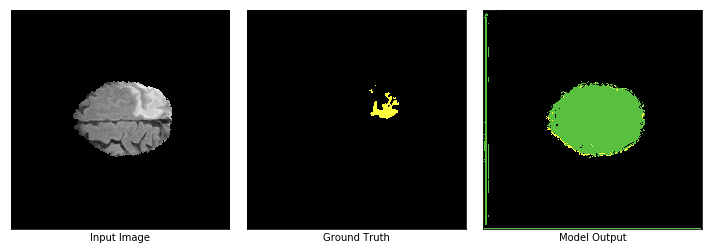

Steps: 46, Loss:0.9931530952453613
Accurary: 0.8678298592567444
Dice coefficient: [1.3491634e-09, 1.3493455e-09, 0.09912609]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.8713194444667848, 0.871336805577893, 0.87385276998167]
Gradient min:-0.0005661179893650115, max:0.0003491195966489613



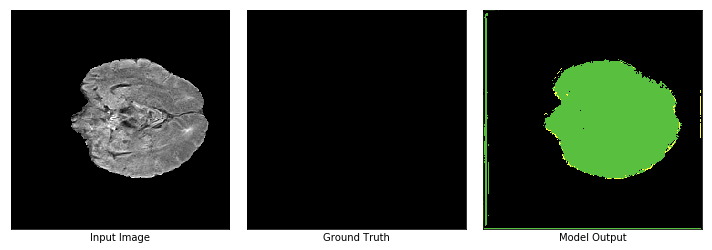

Steps: 47, Loss:0.9995551109313965
Accurary: 0.7321875095367432
Dice coefficient: [6.5841455e-10, 6.584579e-10, 6.4825617e-10]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.7363194444902224, 0.7363368056013304, 0.7321875000464952]
Gradient min:-4.4862488721264526e-05, max:2.6838595658773556e-05



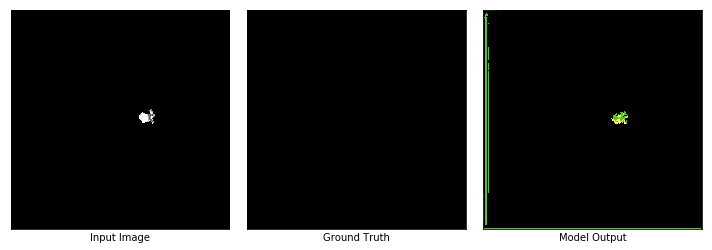

Steps: 48, Loss:0.9904480576515198
Accurary: 0.9779340028762817
Dice coefficient: [8.474576e-09, 8.481764e-09, 7.86782e-09]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9795138888924455, 0.9795312500035536, 0.9779340277816087]
Gradient min:-0.0007185657741501927, max:0.00036176928551867604



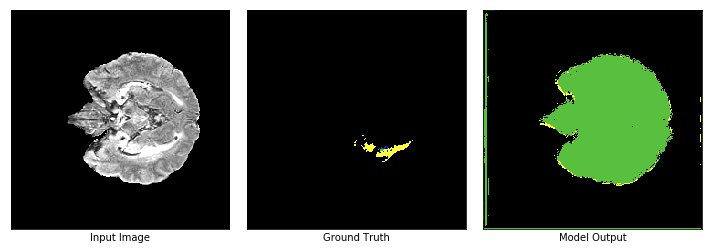

Steps: 49, Loss:0.9972380995750427
Accurary: 0.7281597256660461
Dice coefficient: [0.0045561055, 0.001173633, 0.04894147]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.7343177278321346, 0.7340035769939741, 0.7330047022684278]
Gradient min:-0.0001683014997979626, max:9.948759543476626e-05



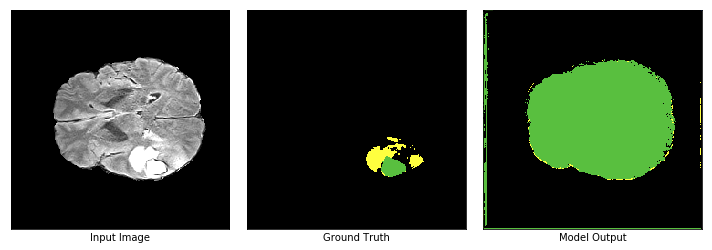

Steps: 50, Loss:0.993410587310791
Accurary: 0.6915451288223267
Dice coefficient: [0.046602573, 0.046605106, 0.12730922]
Sensitivity: [1.0, 1.0, 0.996776792934917]
Specificity: [0.6929737105013077, 0.6929912018867973, 0.6991607374688762]
Gradient min:-0.00028351039509288967, max:0.00017494054918643087



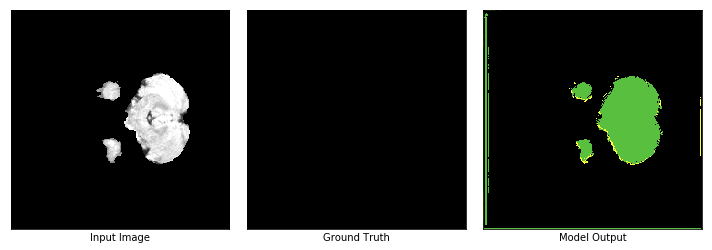

Steps: 51, Loss:0.9945096373558044
Accurary: 0.8826562762260437
Dice coefficient: [1.548467e-09, 1.5487068e-09, 1.4795087e-09]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.8878819444639094, 0.8878993055750175, 0.8826562500203722]
Gradient min:-0.00022082647774368525, max:0.0001634754444239661



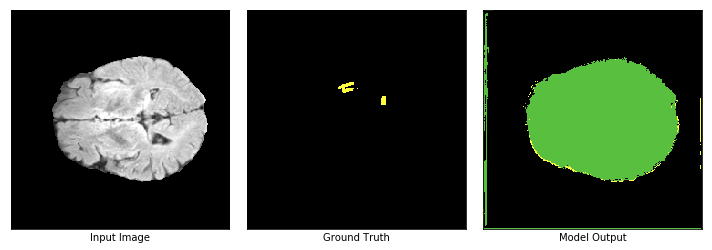

Steps: 52, Loss:0.992229163646698
Accurary: 0.6774652600288391
Dice coefficient: [5.463585e-10, 5.463884e-10, 0.017395016]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.6822395833885001, 0.6822569444996082, 0.6793878510926079]
Gradient min:-0.0003344258584547788, max:0.00021964381448924541



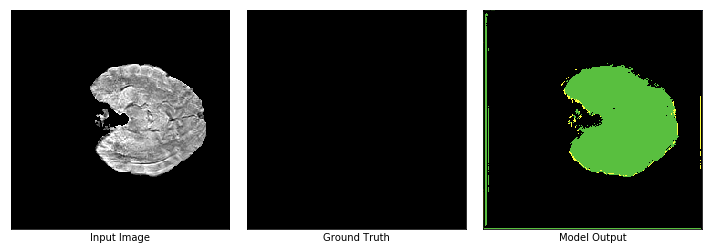

Steps: 53, Loss:0.9927213191986084
Accurary: 0.7892361283302307
Dice coefficient: [8.478169e-10, 8.4788876e-10, 8.237232e-10]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.7952256944799956, 0.7952430555911036, 0.7892361111477021]
Gradient min:-0.000359719357220456, max:0.00016735127428546548



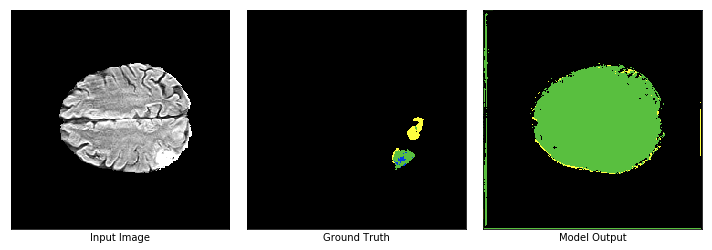

Steps: 54, Loss:0.9935816526412964
Accurary: 0.7565451264381409
Dice coefficient: [0.040991087, 0.034662534, 0.08211814]
Sensitivity: [0.8439306403488254, 0.8367346994307926, 0.9472868225226849]
Specificity: [0.7623048171721968, 0.7617352459146102, 0.7607760513105476]
Gradient min:-0.000432042870670557, max:0.0002523906296119094



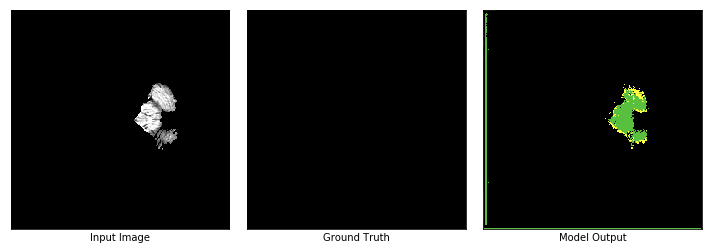

Steps: 55, Loss:0.995160698890686
Accurary: 0.9587152600288391
Dice coefficient: [4.8851976e-09, 4.8875854e-09, 4.2052144e-09]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9644618055617253, 0.9644791666728335, 0.9587152777849453]
Gradient min:-0.00018896046094596386, max:9.327349835075438e-05



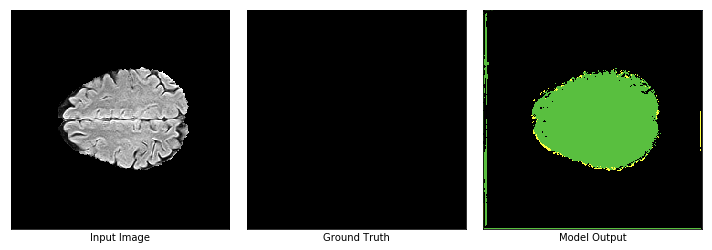

Steps: 56, Loss:0.9978923797607422
Accurary: 0.7824826240539551
Dice coefficient: [8.194706e-10, 8.1953777e-10, 7.9814827e-10]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.7881423611478919, 0.7881597222590001, 0.7824826389266524]
Gradient min:-8.646770584164187e-05, max:6.204689270816743e-05



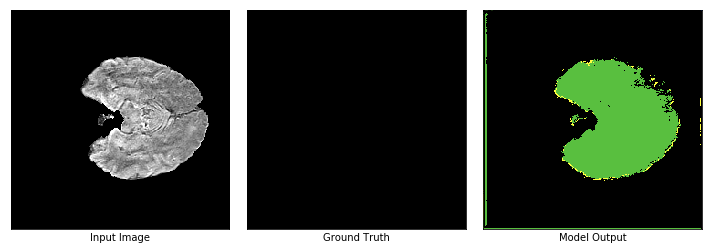

Steps: 57, Loss:0.9956747889518738
Accurary: 0.7711284756660461
Dice coefficient: [7.77484e-10, 7.775445e-10, 7.5855267e-10]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.7767013889276561, 0.7767187500387641, 0.7711284722619569]
Gradient min:-0.0002125458122463897, max:9.890607907436788e-05



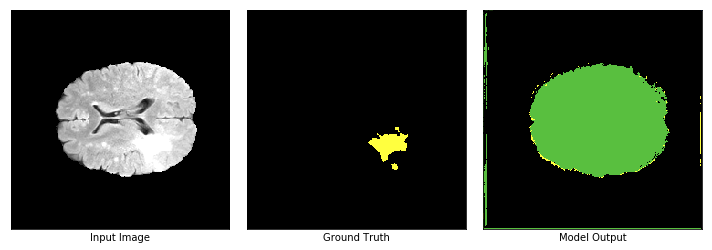

Steps: 58, Loss:0.9984381794929504
Accurary: 0.7239583134651184
Dice coefficient: [6.386104e-10, 6.3865113e-10, 0.09558031]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.7281423611583087, 0.7281597222694167, 0.7341290800087797]
Gradient min:-9.141486225416884e-05, max:6.021500303177163e-05



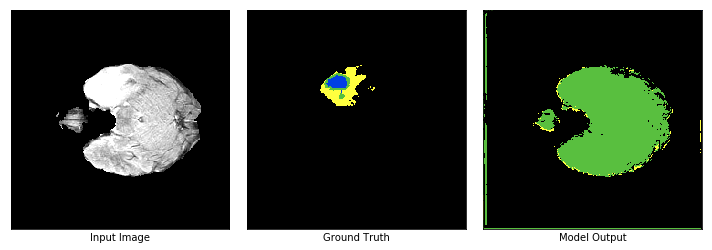

Steps: 59, Loss:0.985502302646637
Accurary: 0.7934722304344177
Dice coefficient: [0.07310876, 0.032474056, 0.19035514]
Sensitivity: [0.9823788550136816, 0.9603960415645524, 0.9799846036952686]
Specificity: [0.8022433766488918, 0.7987386320431481, 0.8081206373229392]
Gradient min:-0.0008956085075624287, max:0.0005690625985153019



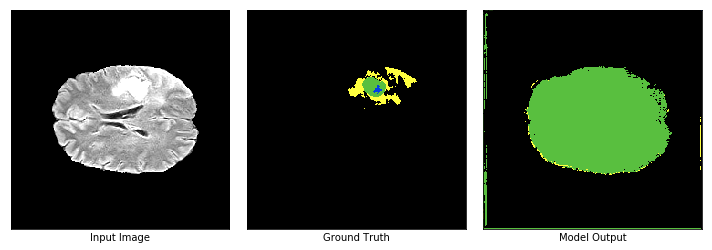

Steps: 60, Loss:0.9922313094139099
Accurary: 0.7311805486679077
Dice coefficient: [0.05225713, 0.046602678, 0.13746108]
Sensitivity: [1.0, 1.0, 0.881688018977483]
Specificity: [0.7367666346530093, 0.7361919240033912, 0.7418655483550076]
Gradient min:-0.0004783284093718976, max:0.0002764126693364233



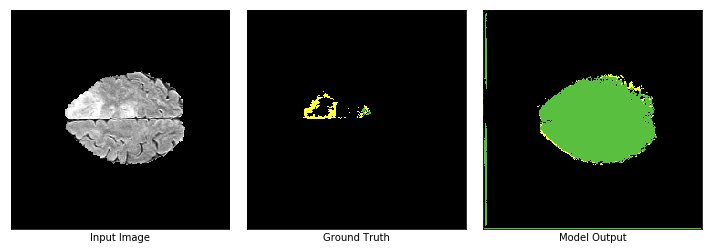

Steps: 61, Loss:0.9919889569282532
Accurary: 0.8242014050483704
Dice coefficient: [0.007686085, 0.0060734903, 0.08827405]
Sensitivity: [1.0, 1.0, 0.9957537155890931]
Specificity: [0.8295403217696501, 0.8294424179556292, 0.8304538850968065]
Gradient min:-0.00042106403270736337, max:0.0003041330201085657



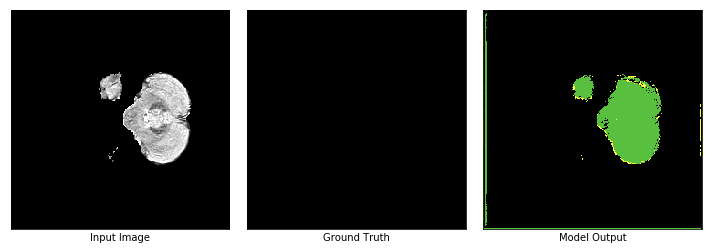

Steps: 62, Loss:0.9983170628547668
Accurary: 0.8918402791023254
Dice coefficient: [1.7021277e-09, 1.7024174e-09, 1.6051364e-09]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.8980034722399299, 0.8980208333510381, 0.8918402777965555]
Gradient min:-6.199036579346284e-05, max:3.5956076317233965e-05



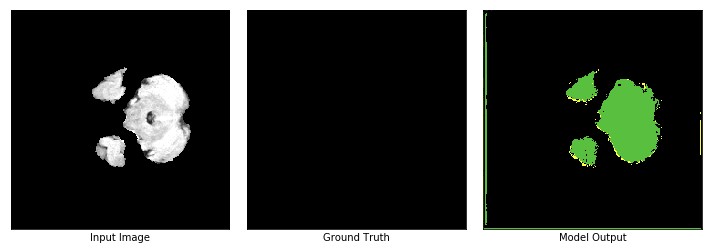

Steps: 63, Loss:0.9837872385978699
Accurary: 0.8811110854148865
Dice coefficient: [1.551109e-09, 1.5513496e-09, 1.4602803e-09]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.8880729166860984, 0.8880902777972065, 0.8811111111317516]
Gradient min:-0.0008759499178268015, max:0.0005106157041154802



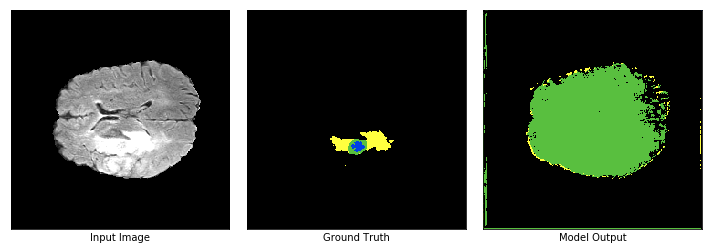

Steps: 64, Loss:0.9977647066116333
Accurary: 0.746059000492096
Dice coefficient: [0.03879544, 0.024595205, 0.12995706]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.7527305719801914, 0.7513584117465416, 0.7564476498989858]
Gradient min:-8.544710726710036e-05, max:7.421976624755189e-05



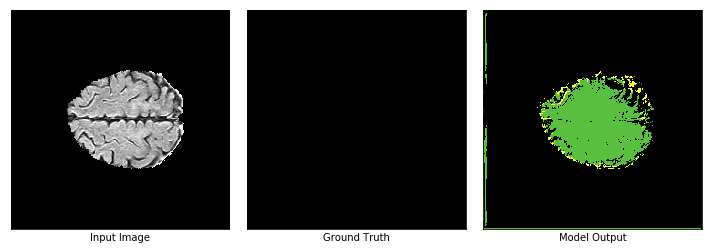

Steps: 65, Loss:0.9844943881034851
Accurary: 0.8480555415153503
Dice coefficient: [1.2181751e-09, 1.2183236e-09, 1.1425959e-09]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.8574826389136315, 0.8575000000247396, 0.8480555555819348]
Gradient min:-0.0016528128180652857, max:0.0009812492644414306



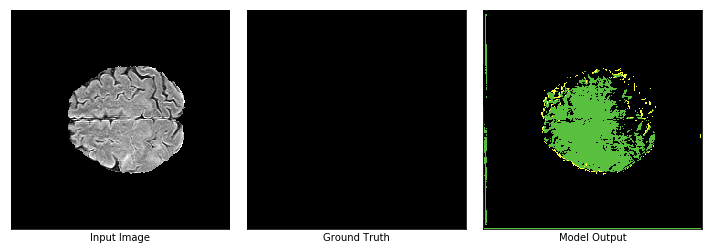

Steps: 66, Loss:0.9939297437667847
Accurary: 0.8630034923553467
Dice coefficient: [1.3477088e-09, 1.3478905e-09, 1.2672665e-09]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.8711805555779201, 0.8711979166890281, 0.8630034722460064]
Gradient min:-0.00047019976773299277, max:0.00028415111592039466



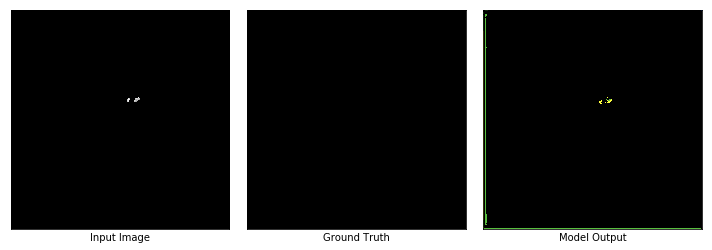

Steps: 67, Loss:0.9879036545753479
Accurary: 0.9869617819786072
Dice coefficient: [1.9120458e-08, 1.9157088e-08, 1.3315579e-08]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9909201388904653, 0.9909375000015733, 0.9869618055578191]
Gradient min:-0.0016568630235269666, max:0.0009400390554219484



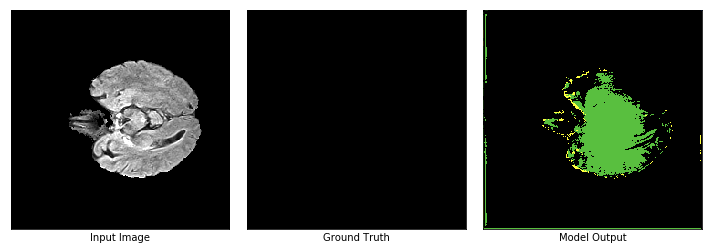

Steps: 68, Loss:0.9903432130813599
Accurary: 0.8718055486679077
Dice coefficient: [1.4275517e-09, 1.4277556e-09, 1.3542795e-09]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.8783854166877804, 0.8784027777988884, 0.8718055555778116]
Gradient min:-0.0016876185545697808, max:0.0007642920245416462



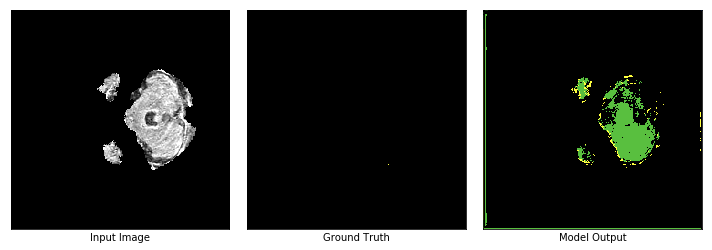

Steps: 69, Loss:0.9935073256492615
Accurary: 0.9325867891311646
Dice coefficient: [2.985966e-09, 2.9868577e-09, 0.0005148031]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9418576388989831, 0.9418750000100912, 0.9325856351789813]
Gradient min:-0.0005035676877014339, max:0.00036033359356224537



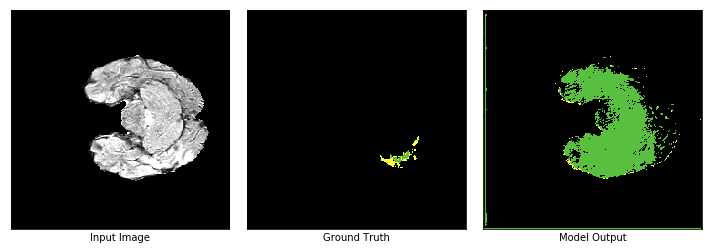

Steps: 70, Loss:0.9813095331192017
Accurary: 0.8514930605888367
Dice coefficient: [0.023002136, 0.023004863, 0.0648697]
Sensitivity: [0.9897959194085797, 0.9897959194085797, 0.9634551507157757]
Specificity: [0.8567180272239717, 0.8567354179234226, 0.854273198510572]
Gradient min:-0.0011073973728343844, max:0.0006362900021485984



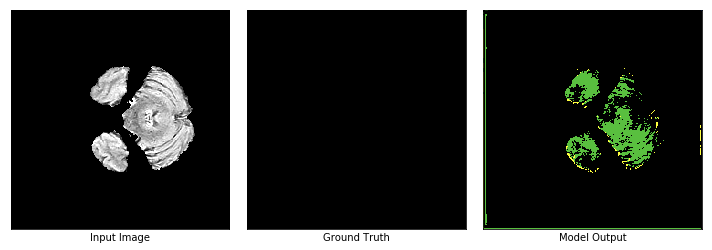

Steps: 71, Loss:0.9962185025215149
Accurary: 0.925243079662323
Dice coefficient: [2.565418e-09, 2.5660765e-09, 2.3223408e-09]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9323263889006378, 0.9323437500117459, 0.9252430555685341]
Gradient min:-0.00022655387874692678, max:0.00016439409228041768



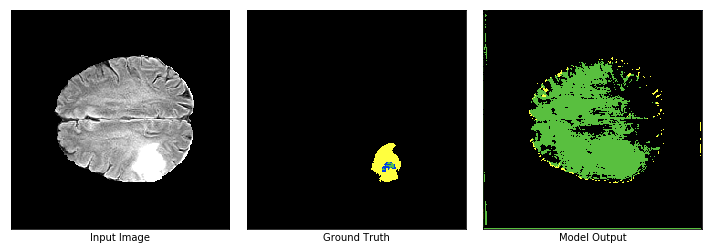

Steps: 72, Loss:0.9857566356658936
Accurary: 0.8144791722297668
Dice coefficient: [0.01785543, 0.006758062, 0.15083607]
Sensitivity: [1.0, 1.0, 0.9500542893588025]
Specificity: [0.8220912237080544, 0.821280291875049, 0.8269905961948887]
Gradient min:-0.000863719149492681, max:0.0008717155433259904



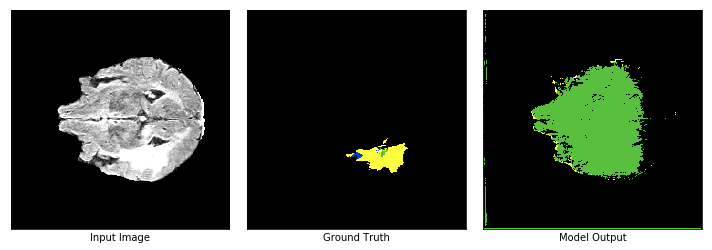

Steps: 73, Loss:0.993665337562561
Accurary: 0.8096180558204651
Dice coefficient: [0.016367817, 0.0066537294, 0.1861347]
Sensitivity: [1.0, 1.0, 0.9860262009954044]
Specificity: [0.8140007998793273, 0.8132687096426119, 0.8254007616995127]
Gradient min:-0.0004416958836372942, max:0.00027218248578719795



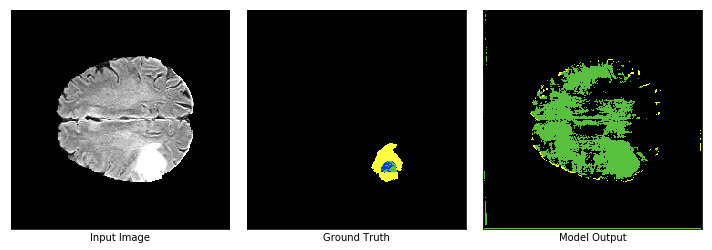

Steps: 74, Loss:0.9815571904182434
Accurary: 0.8530902862548828
Dice coefficient: [0.03993782, 0.017658444, 0.18263091]
Sensitivity: [1.0, 1.0, 0.9326086963846881]
Specificity: [0.860202322730799, 0.8588141220889645, 0.8655963302989421]
Gradient min:-0.0011571135837584734, max:0.0008085620938800275



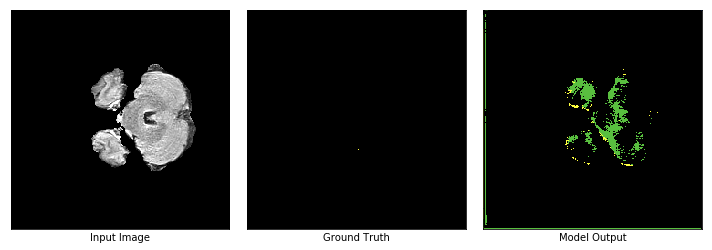

Steps: 75, Loss:0.9936369061470032
Accurary: 0.9566666483879089
Dice coefficient: [4.672897e-09, 4.6750817e-09, 0.0008009652]
Sensitivity: [1.0, 1.0, 0.5000024999875001]
Specificity: [0.9628472222286724, 0.9628645833397804, 0.9566998854202056]
Gradient min:-0.0006393342046067119, max:0.00039592504617758095



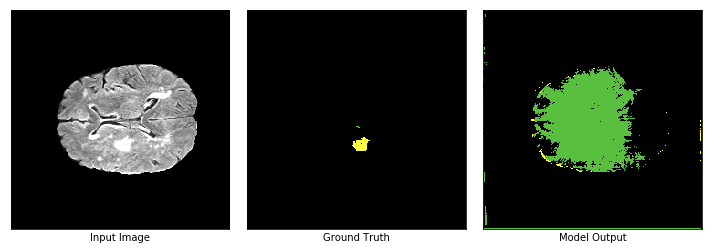

Steps: 76, Loss:0.9870969653129578
Accurary: 0.8355208039283752
Dice coefficient: [0.0010689481, 0.0010690624, 0.040516797]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.8377463321750592, 0.8377636947933391, 0.8382865305835331]
Gradient min:-0.0008663377957418561, max:0.0006903336034156382



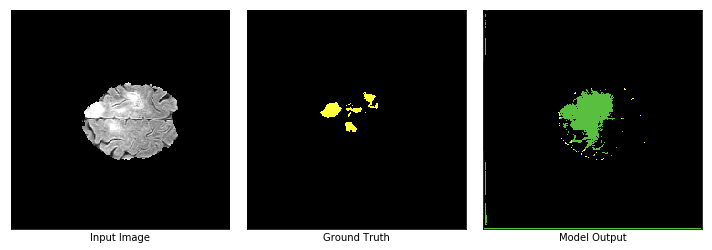

Steps: 77, Loss:0.9960750937461853
Accurary: 0.9516493082046509
Dice coefficient: [3.9323633e-09, 3.93391e-09, 0.31480363]
Sensitivity: [1.0, 1.0, 0.877104379173327]
Specificity: [0.9558506944521092, 0.9558680555632173, 0.9614952812052249]
Gradient min:-0.002113321563228965, max:0.002210075268521905



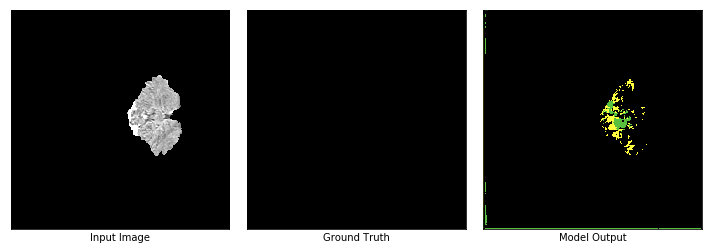

Steps: 78, Loss:0.9942818284034729
Accurary: 0.9763020873069763
Dice coefficient: [1.6366611e-08, 1.6393443e-08, 7.3260074e-09]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9893923611129527, 0.9894097222240608, 0.9763020833374475]
Gradient min:-0.00033986856578849256, max:0.0003039799630641937



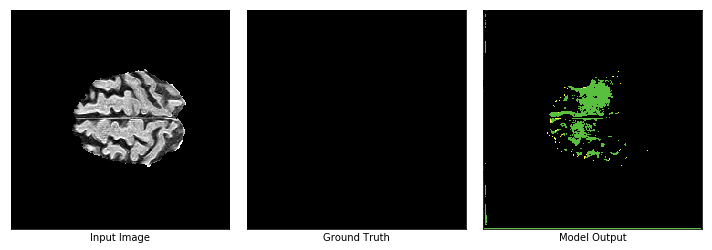

Steps: 79, Loss:0.9959259629249573
Accurary: 0.9542360901832581
Dice coefficient: [4.045307e-09, 4.0469446e-09, 3.7936267e-09]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9570833333407841, 0.9571006944518923, 0.9542361111190563]
Gradient min:-0.00022782034648116678, max:0.00021642170031554997



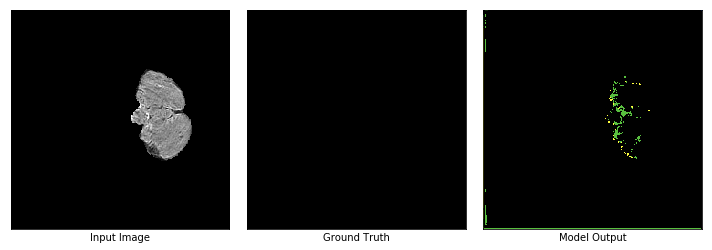

Steps: 80, Loss:0.9921750426292419
Accurary: 0.984375
Dice coefficient: [1.6025641e-08, 1.6051365e-08, 1.1111111e-08]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9891666666685475, 0.9891840277796555, 0.9843750000027127]
Gradient min:-0.0004321909509599209, max:0.0003335721557959914



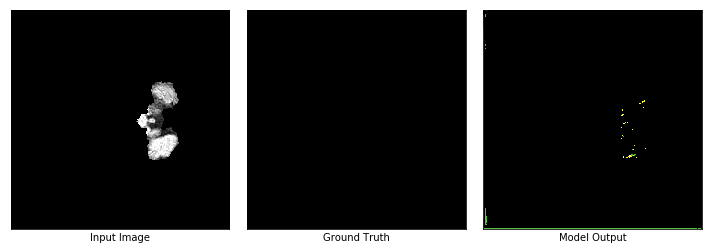

Steps: 81, Loss:0.9968519806861877
Accurary: 0.9902083277702332
Dice coefficient: [3.2051283e-08, 3.215434e-08, 1.7730496e-08]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9945833333342737, 0.9946006944453818, 0.9902083333350333]
Gradient min:-0.0003510056994855404, max:0.00032093716436065733



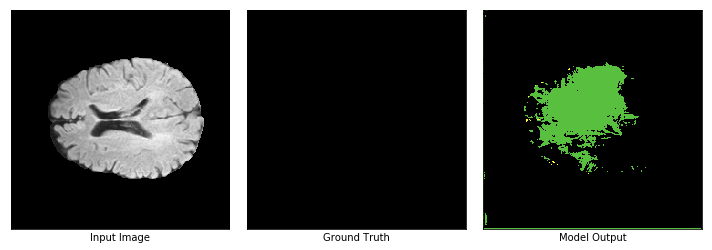

Steps: 82, Loss:0.998469352722168
Accurary: 0.8700867891311646
Dice coefficient: [1.3422818e-09, 1.342462e-09, 1.3363624e-09]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.8706597222446771, 0.8706770833557852, 0.8700868055781099]
Gradient min:-0.0002799808280542493, max:0.00020539667457342148



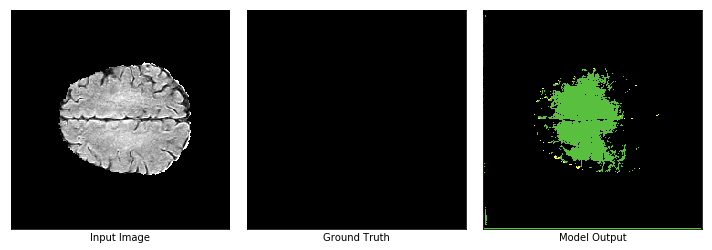

Steps: 83, Loss:0.9918308258056641
Accurary: 0.8965451121330261
Dice coefficient: [1.7050298e-09, 1.7053206e-09, 1.6781339e-09]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.8981770833510109, 0.898194444462119, 0.8965451389068498]
Gradient min:-0.0008836871129460633, max:0.000474515778478235



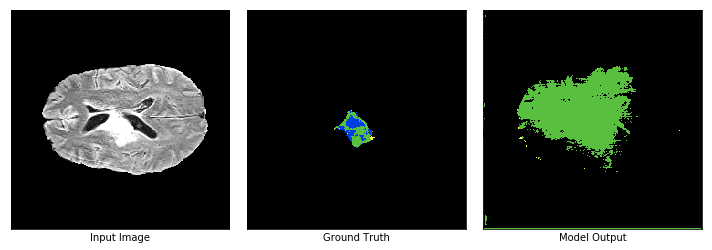

Steps: 84, Loss:0.9900092482566833
Accurary: 0.8654687404632568
Dice coefficient: [0.18707258, 0.11471836, 0.18981786]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.8701367352921242, 0.8648511383774341, 0.8698510619776415]
Gradient min:-0.0004838059830944985, max:0.0005053915665484965



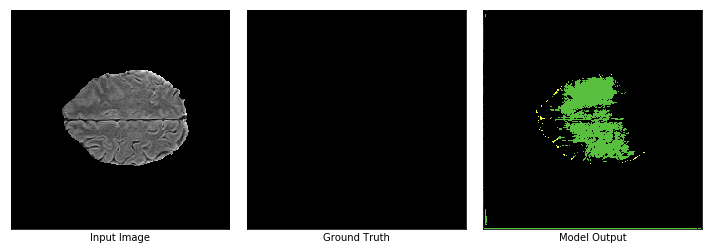

Steps: 85, Loss:0.990062952041626
Accurary: 0.917638897895813
Dice coefficient: [2.1720243e-09, 2.1724962e-09, 2.1079258e-09]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9200694444583213, 0.9200868055694293, 0.9176388889031877]
Gradient min:-0.0006440121796913445, max:0.00043770932825282216



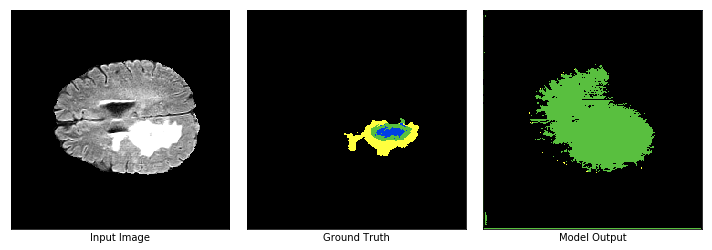

Steps: 86, Loss:0.9828853607177734
Accurary: 0.8457986116409302
Dice coefficient: [0.14192644, 0.09261165, 0.31704238]
Sensitivity: [1.0, 1.0, 0.9832214766039067]
Specificity: [0.8495219011724808, 0.8457042869911279, 0.8648319358086376]
Gradient min:-0.0009716289350762963, max:0.0006218818016350269



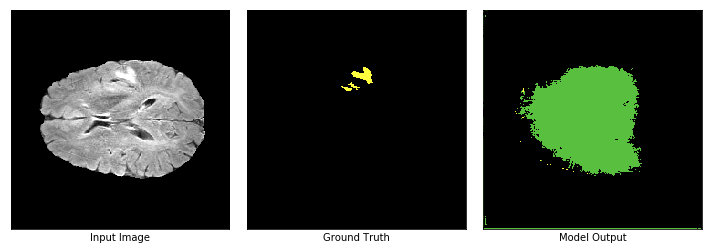

Steps: 87, Loss:0.9889887571334839
Accurary: 0.7952951192855835
Dice coefficient: [8.501955e-10, 8.502678e-10, 0.047686066]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.7957986111465628, 0.7958159722576709, 0.7992915969082754]
Gradient min:-0.0017366240499541163, max:0.0016259100520983338



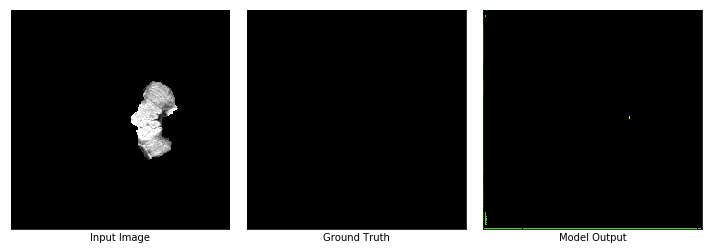

Steps: 88, Loss:0.9859813451766968
Accurary: 0.9912499785423279
Dice coefficient: [2.4213074e-08, 2.4271843e-08, 1.984127e-08]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9928298611123559, 0.992847222223464, 0.9912500000015191]
Gradient min:-0.0006907584611326456, max:0.0005916235386393964



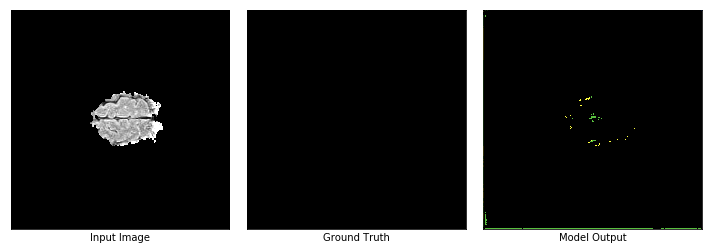

Steps: 89, Loss:0.9932311177253723
Accurary: 0.9902430772781372
Dice coefficient: [2.2471909e-08, 2.2522523e-08, 1.7793594e-08]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9922743055568968, 0.992291666668005, 0.9902430555572495]
Gradient min:-0.0012722774408757687, max:0.0006281595560722053



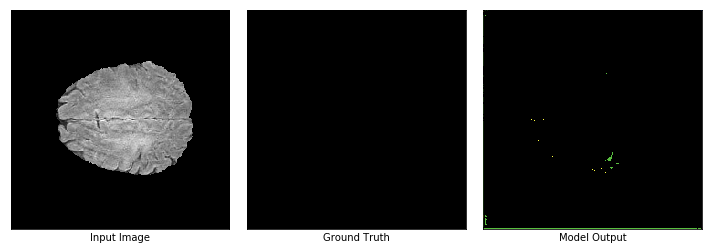

Steps: 90, Loss:0.9961565732955933
Accurary: 0.9914757013320923
Dice coefficient: [2.1097046e-08, 2.1141648e-08, 2.0366599e-08]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.991770833334762, 0.9917881944458701, 0.9914756944459243]
Gradient min:-0.0011706516379490495, max:0.0006666971603408456



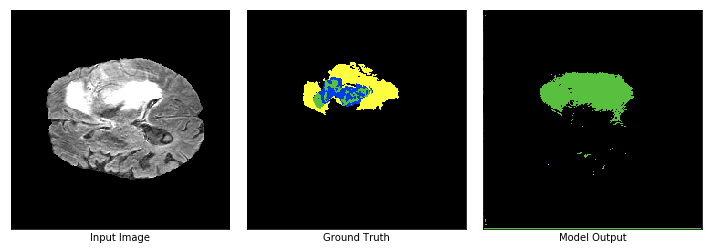

Steps: 91, Loss:0.9898651242256165
Accurary: 0.9295312762260437
Dice coefficient: [0.4470725, 0.21728395, 0.7812207]
Sensitivity: [0.9664710815886749, 0.985743381145756, 0.8360608675393028]
Specificity: [0.9501480312815523, 0.9390638953686697, 0.9804128092872086]
Gradient min:-0.0019442293560132384, max:0.0006904248730279505



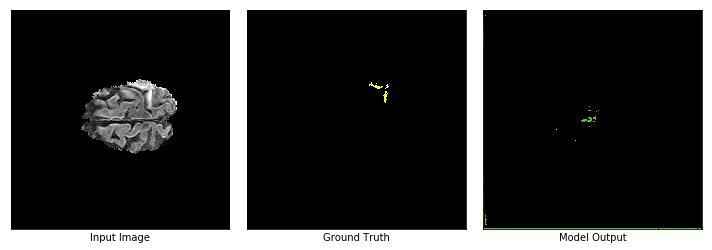

Steps: 92, Loss:0.9923458695411682
Accurary: 0.9892361164093018
Dice coefficient: [2.0576131e-08, 2.0618556e-08, 1.6129032e-08]
Sensitivity: [1.0, 1.0, 1.2048191319495023e-07]
Specificity: [0.9915625000014648, 0.9915798611125729, 0.990663629884962]
Gradient min:-0.002663278253749013, max:0.0011450006859377027



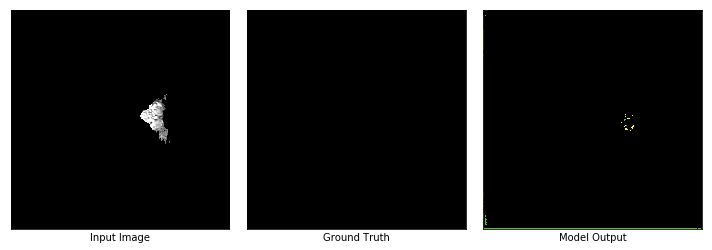

Steps: 93, Loss:0.984976589679718
Accurary: 0.9909722208976746
Dice coefficient: [2.2123894e-08, 2.2172948e-08, 1.9230768e-08]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9921527777791401, 0.9921701388902482, 0.9909722222237896]
Gradient min:-0.001345423050224781, max:0.0012246653204783797



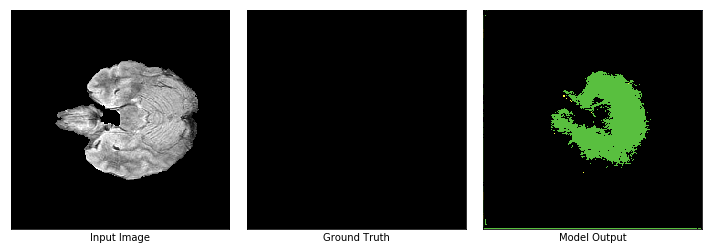

Steps: 94, Loss:0.9880750775337219
Accurary: 0.8886111378669739
Dice coefficient: [1.5678896e-09, 1.5681354e-09, 1.5586035e-09]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.8892708333525572, 0.8892881944636652, 0.8886111111304494]
Gradient min:-0.0007816582801751792, max:0.0006833135266788304



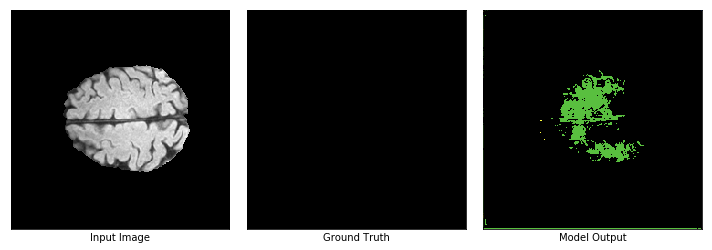

Steps: 95, Loss:0.9892503619194031
Accurary: 0.9397222399711609
Dice coefficient: [2.8893383e-09, 2.8901734e-09, 2.8801843e-09]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9399131944548762, 0.9399305555659843, 0.9397222222326871]
Gradient min:-0.0010448709363117814, max:0.0014061146648600698



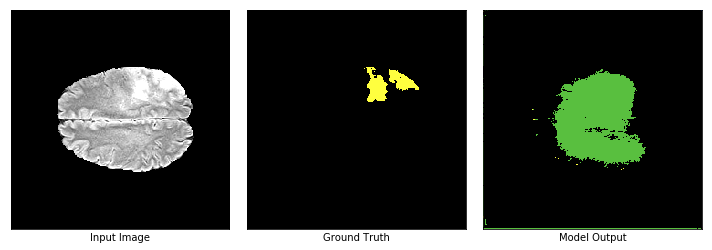

Steps: 96, Loss:0.974205493927002
Accurary: 0.8569617867469788
Dice coefficient: [1.2794268e-09, 1.2795905e-09, 0.12664847]
Sensitivity: [1.0, 1.0, 0.5796045829385579]
Specificity: [0.8643055555791136, 0.8643229166902218, 0.87150196863089]
Gradient min:-0.0028747247997671366, max:0.0030678249895572662



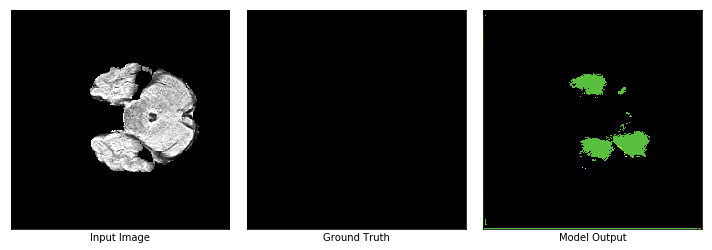

Steps: 97, Loss:0.9892693161964417
Accurary: 0.9547743201255798
Dice coefficient: [3.8910506e-09, 3.892565e-09, 3.8387715e-09]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9553819444521906, 0.9553993055632988, 0.9547743055634073]
Gradient min:-0.0007262690342031419, max:0.000671022105962038



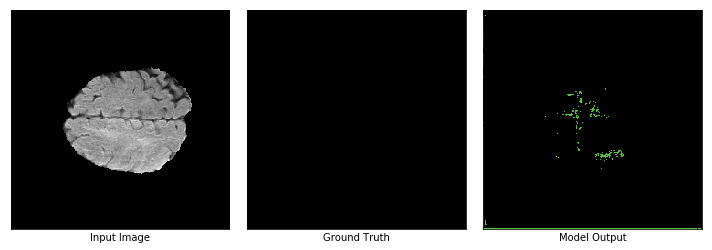

Steps: 98, Loss:0.9948484301567078
Accurary: 0.9879860877990723
Dice coefficient: [1.4662756e-08, 1.4684288e-08, 1.4450866e-08]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9881597222242778, 0.9881770833353859, 0.9879861111131969]
Gradient min:-0.0002983050362672657, max:0.00036450449260883033



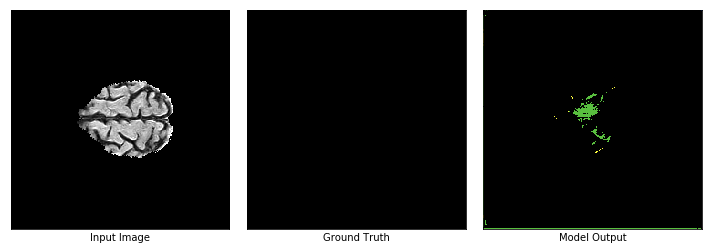

Steps: 99, Loss:0.977120578289032
Accurary: 0.9832118153572083
Dice coefficient: [1.0799136e-08, 1.0810811e-08, 1.0341261e-08]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9839236111139021, 0.9839409722250102, 0.9832118055584702]
Gradient min:-0.0015904149040579796, max:0.001099877175875008



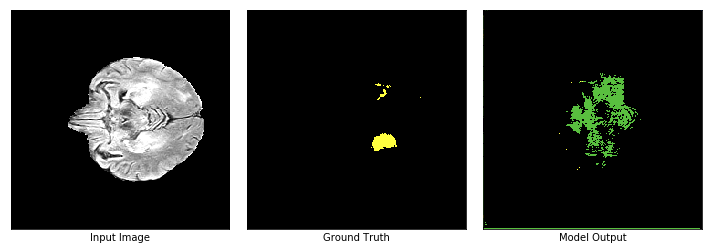

Steps: 100, Loss:0.9826663732528687
Accurary: 0.9436979293823242
Dice coefficient: [3.4530385e-09, 3.4542313e-09, 0.058665074]
Sensitivity: [1.0, 1.0, 0.23058825339792346]
Specificity: [0.949722222230951, 0.9497395833420591, 0.9507127241013182]
Gradient min:-0.002145233564078808, max:0.0010817835573107004



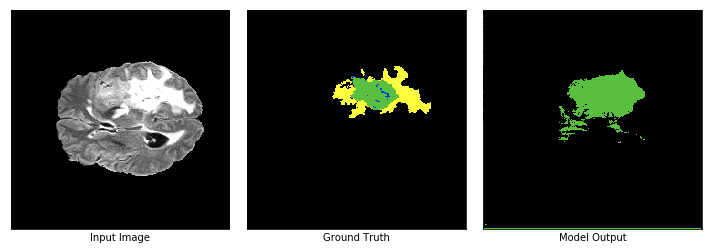

Steps: 101, Loss:0.9627400040626526
Accurary: 0.9406076669692993
Dice coefficient: [0.48255587, 0.46514398, 0.679701]
Sensitivity: [0.9800955415597489, 0.9840336135795494, 0.7603731110956156]
Specificity: [0.9535886696092595, 0.9525970572677545, 0.972784496527356]
Gradient min:-0.0031581304501742125, max:0.001806303858757019



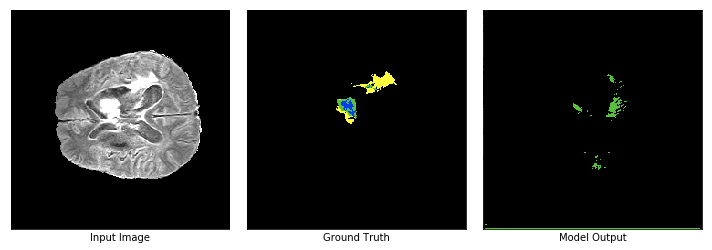

Steps: 102, Loss:0.9952309727668762
Accurary: 0.9733680486679077
Dice coefficient: [0.06701941, 0.059701502, 0.106537536]
Sensitivity: [0.10857145404081561, 0.13513517409301018, 0.10173411443081949]
Specificity: [0.9869694323166865, 0.9868765031916629, 0.987679562882228]
Gradient min:-0.003685580799356103, max:0.001829212880693376



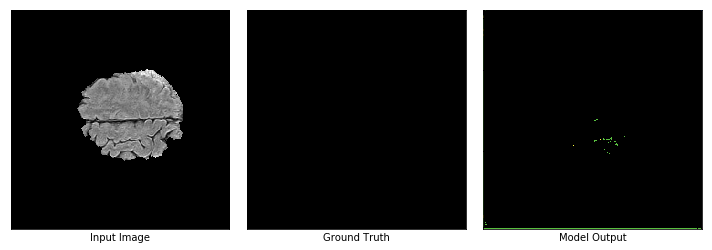

Steps: 103, Loss:0.998182475566864
Accurary: 0.9910764098167419
Dice coefficient: [2e-08, 2.004008e-08, 1.9455252e-08]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9913194444459514, 0.9913368055570596, 0.9910763888904381]
Gradient min:-0.0006113244453445077, max:0.0003172213619109243



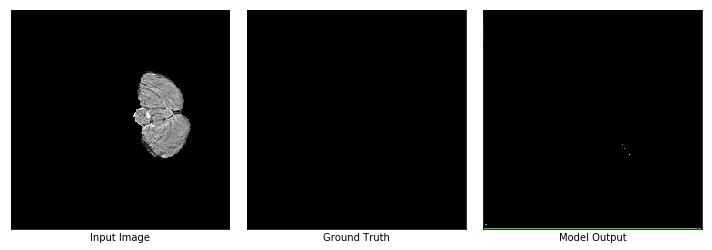

Steps: 104, Loss:0.9613236784934998
Accurary: 0.991736114025116
Dice coefficient: [2.1786493e-08, 2.183406e-08, 2.1008402e-08]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9920312500013835, 0.9920486111124915, 0.9917361111125458]
Gradient min:-0.003106870222836733, max:0.0031564265955239534



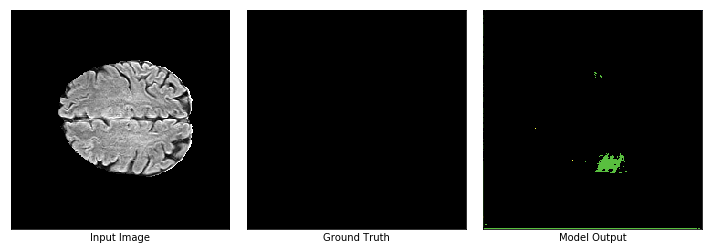

Steps: 105, Loss:0.9625414609909058
Accurary: 0.9860243201255798
Dice coefficient: [1.2499999e-08, 1.25156445e-08, 1.242236e-08]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9861111111135223, 0.9861284722246305, 0.9860243055579819]
Gradient min:-0.004609566647559404, max:0.0043318187817931175



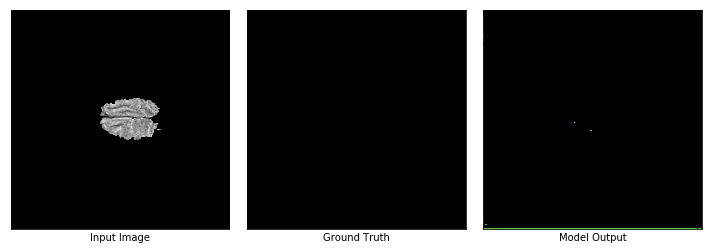

Steps: 106, Loss:0.9813831448554993
Accurary: 0.9917708039283752
Dice coefficient: [2.173913e-08, 2.1786493e-08, 2.1097046e-08]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9920138888902754, 0.9920312500013835, 0.991770833334762]
Gradient min:-0.0021721473895013332, max:0.0018743412801995873



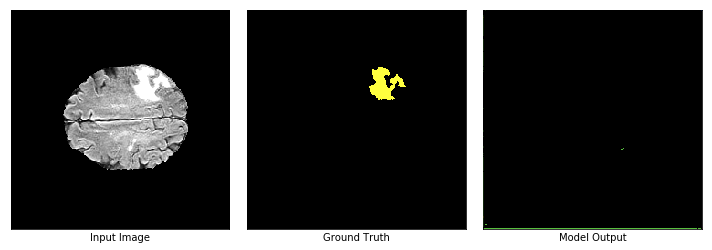

Steps: 107, Loss:0.9736429452896118
Accurary: 0.9804166555404663
Dice coefficient: [2.6246719e-08, 2.6315789e-08, 8.865248e-09]
Sensitivity: [1.0, 1.0, 1.3458950020740916e-08]
Specificity: [0.993385416667815, 0.9934027777789232, 0.9932286262037694]
Gradient min:-0.016240693628787994, max:0.01138875912874937



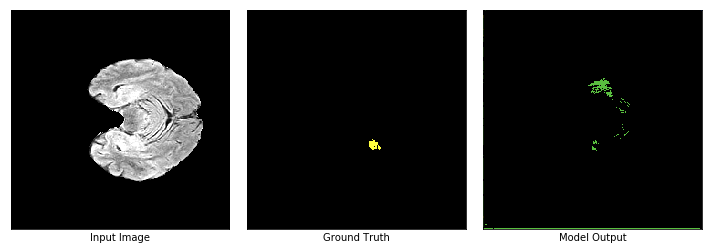

Steps: 108, Loss:0.9999692440032959
Accurary: 0.9863541722297668
Dice coefficient: [1.4367815e-08, 1.4388489e-08, 1.2722646e-08]
Sensitivity: [1.0, 1.0, 1.21951204640097e-07]
Specificity: [0.9879166666687644, 0.9879340277798726, 0.9877603532828401]
Gradient min:-3.775970526476158e-06, max:3.3117153179773595e-06



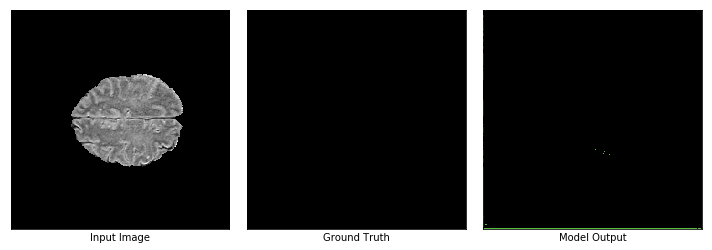

Steps: 109, Loss:0.9821794629096985
Accurary: 0.9928992986679077
Dice coefficient: [2.4999999e-08, 2.5062656e-08, 2.4449877e-08]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9930555555567612, 0.9930729166678692, 0.9928993055567883]
Gradient min:-0.004847267176955938, max:0.0029829703271389008



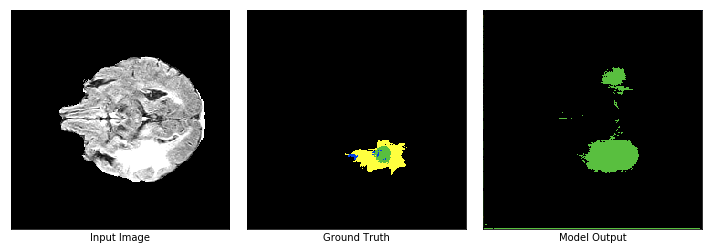

Steps: 110, Loss:0.9897007942199707
Accurary: 0.9557291865348816
Dice coefficient: [0.2108072, 0.17693093, 0.6099431]
Sensitivity: [0.9937106920216764, 1.0, 0.9092920360671679]
Specificity: [0.9587304912610016, 0.9578130450021254, 0.9741483536067583]
Gradient min:-0.004724062513560057, max:0.002215177984908223



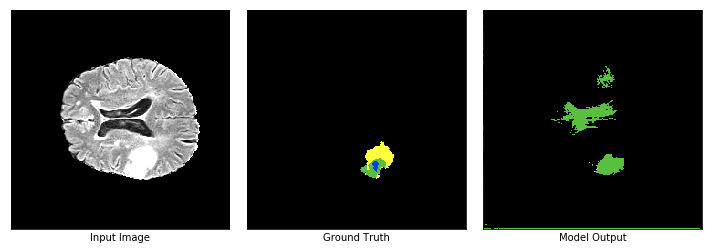

Steps: 111, Loss:0.9637660384178162
Accurary: 0.9607986211776733
Dice coefficient: [0.24772163, 0.2046709, 0.29884276]
Sensitivity: [0.8925373166406771, 0.8700361057748699, 0.5134502980883006]
Specificity: [0.9689164411125615, 0.967953526513275, 0.9710282844354519]
Gradient min:-0.004403135273605585, max:0.004904476925730705



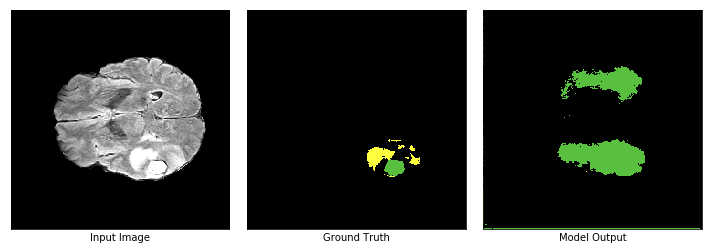

Steps: 112, Loss:0.981011152267456
Accurary: 0.9226388931274414
Dice coefficient: [0.124923706, 0.12494913, 0.2692587]
Sensitivity: [0.9593750012695312, 0.9593750012695312, 0.8169790538370556]
Specificity: [0.9251396648175385, 0.925157122918094, 0.9319845483689372]
Gradient min:-0.0021087885834276676, max:0.0014586519682779908



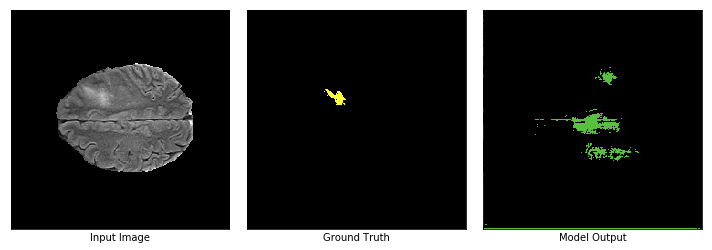

Steps: 113, Loss:0.9966576099395752
Accurary: 0.9697569608688354
Dice coefficient: [6.3451777e-09, 6.349206e-09, 5.740528e-09]
Sensitivity: [1.0, 1.0, 6.172839125133388e-08]
Specificity: [0.972638888893639, 0.9726562500047472, 0.9724920784197757]
Gradient min:-0.0008448848384432495, max:0.00040239322697743773



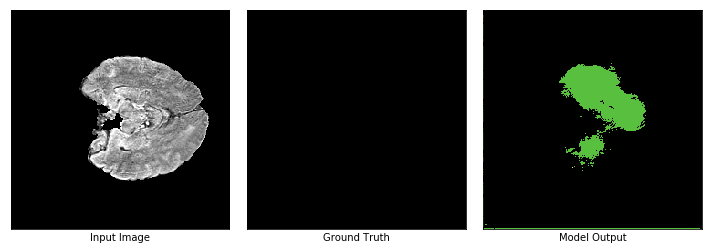

Steps: 114, Loss:0.9811655879020691
Accurary: 0.9139583110809326
Dice coefficient: [2.0197939e-09, 2.020202e-09, 2.0177562e-09]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9140451389038116, 0.9140625000149197, 0.9139583333482711]
Gradient min:-0.0016160240629687905, max:0.0017491207690909505



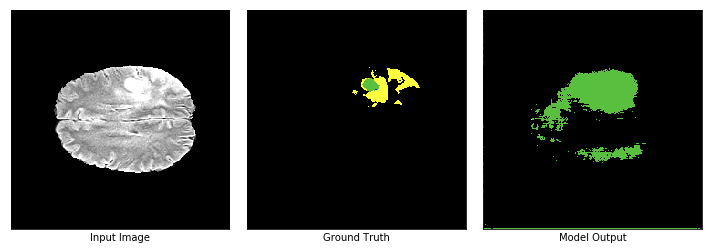

Steps: 115, Loss:0.9642919898033142
Accurary: 0.9158853888511658
Dice coefficient: [0.077424616, 0.076656476, 0.2895497]
Sensitivity: [1.0, 1.0, 0.7319587651893577]
Specificity: [0.9211287232326897, 0.9211140528249993, 0.9314444680821737]
Gradient min:-0.0049972087144851685, max:0.005635359790176153



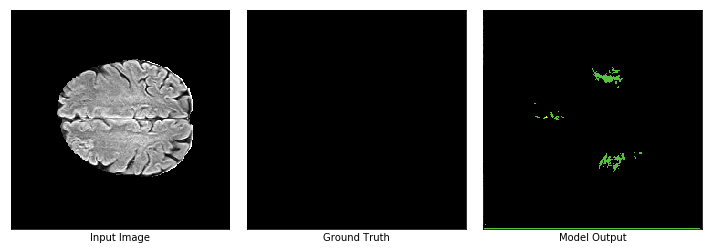

Steps: 116, Loss:0.9781029224395752
Accurary: 0.9863368272781372
Dice coefficient: [1.2771392e-08, 1.2787724e-08, 1.270648e-08]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.98640625000236, 0.9864236111134681, 0.9863368055579277]
Gradient min:-0.005120900925248861, max:0.0067357877269387245



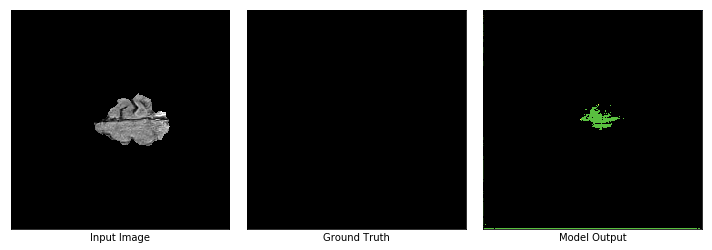

Steps: 117, Loss:0.9588602185249329
Accurary: 0.9864062666893005
Dice coefficient: [1.2870013e-08, 1.2886598e-08, 1.2771392e-08]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9865104166690086, 0.9865277777801167, 0.98640625000236]
Gradient min:-0.002970886416733265, max:0.003210781142115593



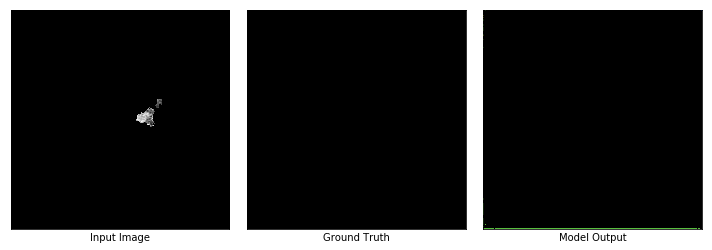

Steps: 118, Loss:0.9985246658325195
Accurary: 0.9951736330986023
Dice coefficient: [3.649635e-08, 3.6630034e-08, 3.5971222e-08]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9952430555563814, 0.9952604166674895, 0.995173611111949]
Gradient min:-0.0017249566735699773, max:0.001484573120251298



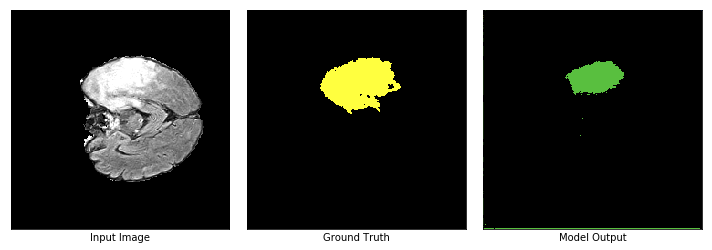

Steps: 119, Loss:0.9564200043678284
Accurary: 0.932934045791626
Dice coefficient: [4.9382716e-09, 4.9407114e-09, 0.5942504]
Sensitivity: [1.0, 1.0, 0.47101240417937]
Specificity: [0.9648437500061036, 0.9648611111172116, 0.9926846840203416]
Gradient min:-0.022250663489103317, max:0.01223895326256752



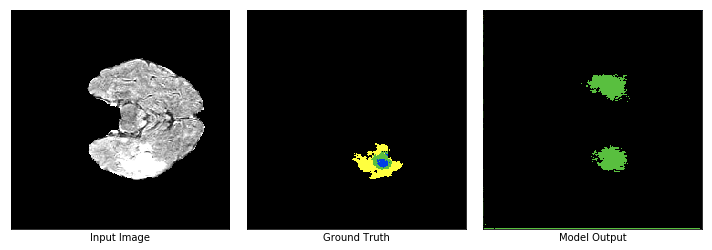

Steps: 120, Loss:0.9810113310813904
Accurary: 0.9622743129730225
Dice coefficient: [0.26474687, 0.188441, 0.38153845]
Sensitivity: [0.9283387645492259, 0.9065420604419598, 0.5185873650688907]
Specificity: [0.9727540886368746, 0.9712299167094361, 0.977160144367497]
Gradient min:-0.003314042929559946, max:0.001837397227063775



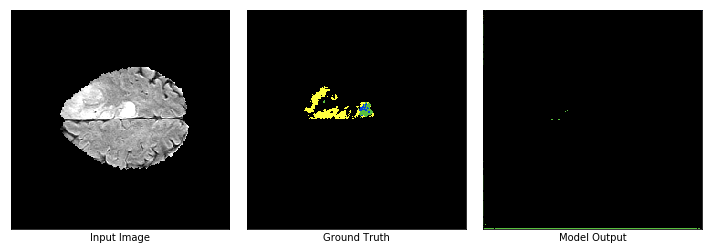

Steps: 121, Loss:0.9944912791252136
Accurary: 0.9790798425674438
Dice coefficient: [1.9646365e-08, 2.1929823e-08, 0.008264471]
Sensitivity: [5.917159413185834e-08, 8.547007816495059e-08, 0.005767024154936284]
Specificity: [0.9940798523455834, 0.9941026042492385, 0.9940422681694883]
Gradient min:-0.002146698534488678, max:0.0015556965954601765



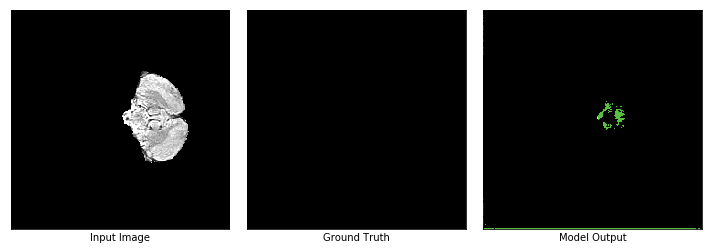

Steps: 122, Loss:0.9560372233390808
Accurary: 0.9909374713897705
Dice coefficient: [1.9342359e-08, 1.9379845e-08, 1.9157088e-08]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9910243055571138, 0.9910416666682219, 0.9909375000015733]
Gradient min:-0.003014159156009555, max:0.0038576037622988224



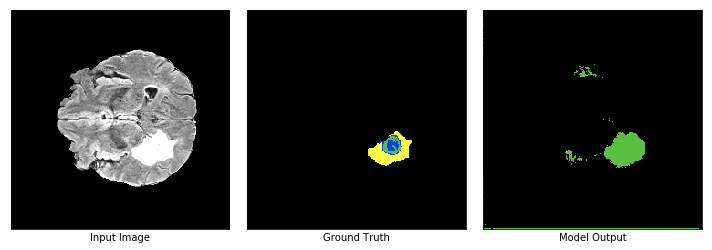

Steps: 123, Loss:0.9627032279968262
Accurary: 0.9725173711776733
Dice coefficient: [0.35491607, 0.20241217, 0.7404255]
Sensitivity: [1.0, 1.0, 0.9465095199772482]
Specificity: [0.9764983400355586, 0.9735049732657158, 0.9880878630744839]
Gradient min:-0.004923734348267317, max:0.004886206239461899



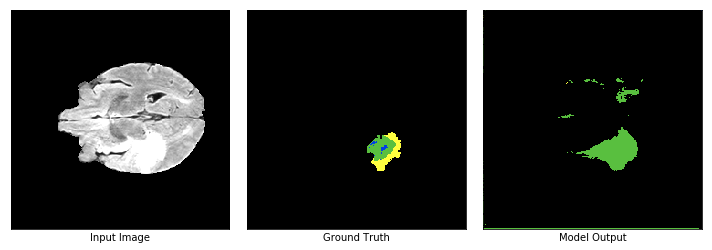

Steps: 124, Loss:0.978243887424469
Accurary: 0.9720138907432556
Dice coefficient: [0.4181132, 0.38846153, 0.62932986]
Sensitivity: [0.9892857144770408, 0.9882583172552188, 0.9778672034419799]
Specificity: [0.9730715287564742, 0.972253849257781, 0.9801611136663674]
Gradient min:-0.001462440937757492, max:0.002464338904246688



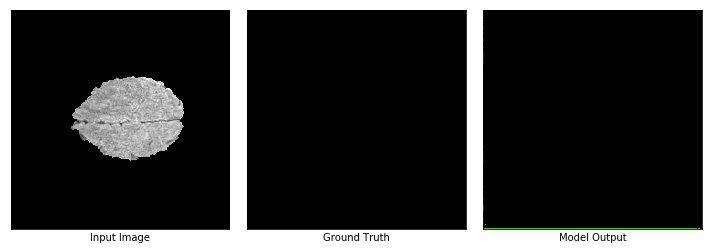

Steps: 125, Loss:0.9665800333023071
Accurary: 0.9946527481079102
Dice coefficient: [3.2786886e-08, 3.2894736e-08, 3.2467533e-08]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9947048611120304, 0.9947222222231386, 0.9946527777787061]
Gradient min:-0.00500184390693903, max:0.005655562970787287



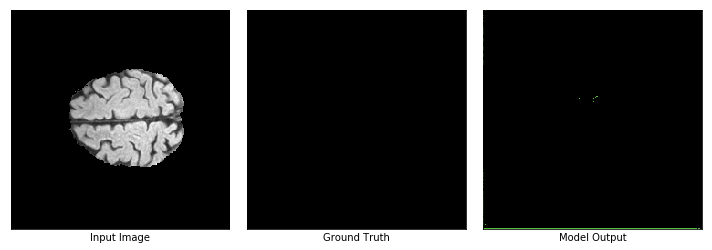

Steps: 126, Loss:0.9532783031463623
Accurary: 0.9943055510520935
Dice coefficient: [3.076923e-08, 3.0864197e-08, 3.0487804e-08]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9943576388898685, 0.9943750000009766, 0.9943055555565442]
Gradient min:-0.0033550607040524483, max:0.0030327702406793833



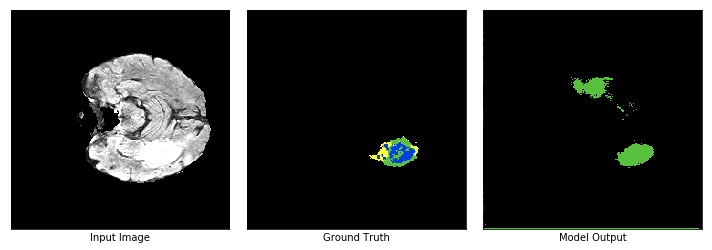

Steps: 127, Loss:0.9792646169662476
Accurary: 0.9692361354827881
Dice coefficient: [0.49960846, 0.2678406, 0.5172662]
Sensitivity: [0.7523584934863385, 0.6379691029145893, 0.6713352038157311]
Specificity: [0.9811812799582074, 0.9752217964240955, 0.9824868651519597]
Gradient min:-0.005193782038986683, max:0.004068200010806322



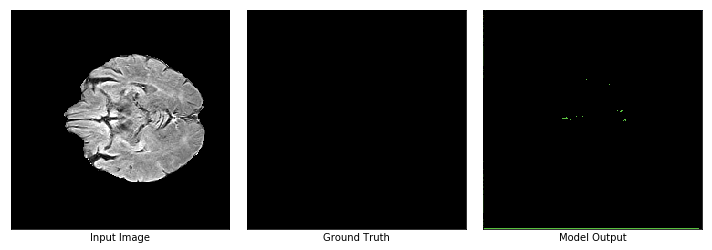

Steps: 128, Loss:0.9639256000518799
Accurary: 0.9937673807144165
Dice coefficient: [2.8089888e-08, 2.8169014e-08, 2.7855153e-08]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9938194444455175, 0.9938368055566256, 0.9937673611121932]
Gradient min:-0.008775254711508751, max:0.004527943208813667



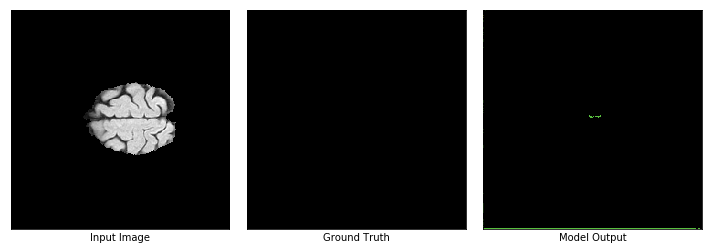

Steps: 129, Loss:0.9847117066383362
Accurary: 0.9948263764381409
Dice coefficient: [3.3898303e-08, 3.3898303e-08, 3.3557047e-08]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9948784722231114, 0.9948784722231114, 0.9948263888897871]
Gradient min:-0.002782320138067007, max:0.0028072292916476727



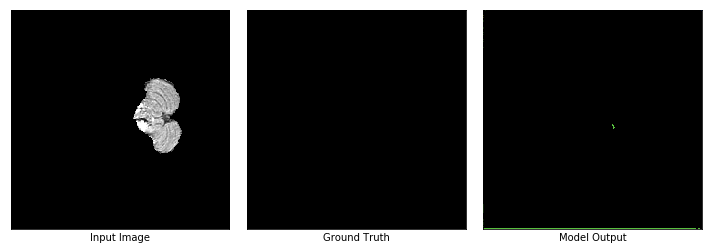

Steps: 130, Loss:0.9818872213363647
Accurary: 0.9952256679534912
Dice coefficient: [3.6764703e-08, 3.6900367e-08, 3.6363634e-08]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9952777777785976, 0.9952951388897057, 0.9952256944452733]
Gradient min:-0.001729004317894578, max:0.0019291096832603216



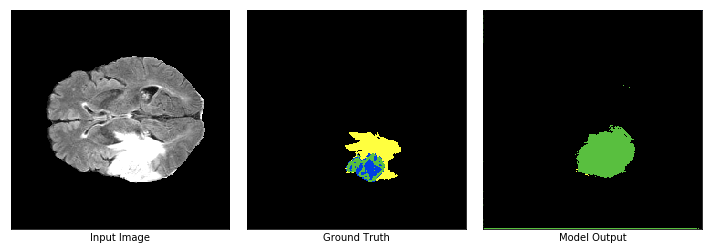

Steps: 131, Loss:0.9680114388465881
Accurary: 0.9527257084846497
Dice coefficient: [0.42198393, 0.25134972, 0.7712163]
Sensitivity: [0.911935111101563, 0.895299147536343, 0.8807503355035714]
Specificity: [0.9633396196550154, 0.9571693621863108, 0.9836888784552864]
Gradient min:-0.004737460054457188, max:0.003944298718124628



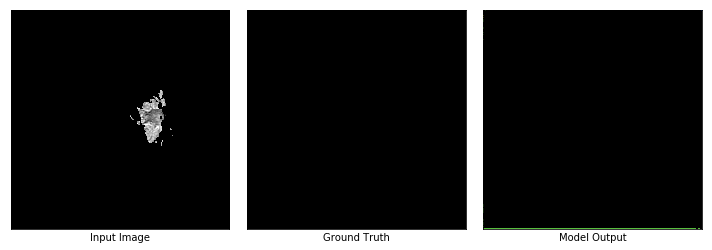

Steps: 132, Loss:0.9703540802001953
Accurary: 0.995434045791626
Dice coefficient: [3.8461536e-08, 3.8610036e-08, 3.802281e-08]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9954861111118948, 0.9955034722230028, 0.9954340277785705]
Gradient min:-0.00470334105193615, max:0.0034637702628970146



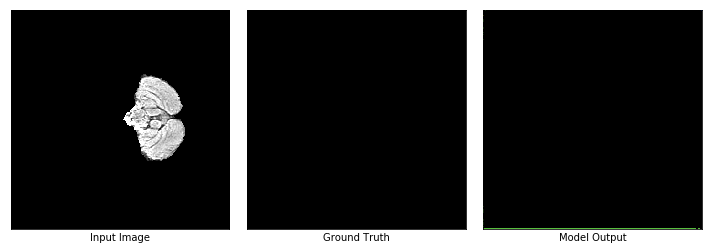

Steps: 133, Loss:0.9765684008598328
Accurary: 0.9955034852027893
Dice coefficient: [3.8910503e-08, 3.90625e-08, 3.8610036e-08]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9955381944452191, 0.9955555555563271, 0.9955034722230028]
Gradient min:-0.009433585219085217, max:0.006533035542815924



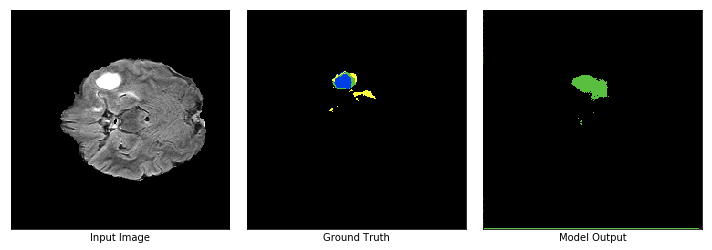

Steps: 134, Loss:0.9667876362800598
Accurary: 0.981041669845581
Dice coefficient: [0.39398497, 0.10740741, 0.5006519]
Sensitivity: [0.7380281763935724, 0.5471698540405798, 0.6894075459711392]
Specificity: [0.9875447637369997, 0.9840679027404481, 0.9896043335747411]
Gradient min:-0.002160669770091772, max:0.0030952878296375275



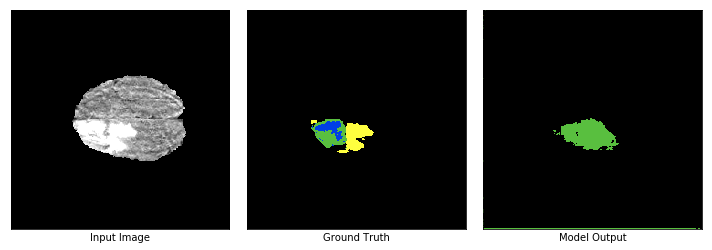

Steps: 135, Loss:0.9457911849021912
Accurary: 0.9659201502799988
Dice coefficient: [0.3458705, 0.22958058, 0.62904716]
Sensitivity: [0.4994400951910404, 0.4490500958713282, 0.6559485552672119]
Specificity: [0.9781332110712728, 0.9749916697400972, 0.9880810063363225]
Gradient min:-0.007255949545651674, max:0.007581526413559914



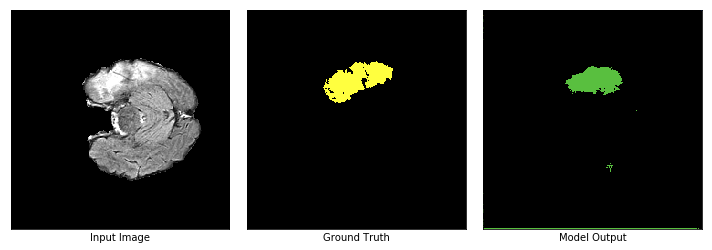

Steps: 136, Loss:0.9582687020301819
Accurary: 0.9586805701255798
Dice coefficient: [6.1462813e-09, 6.1500613e-09, 0.6423274]
Sensitivity: [1.0, 1.0, 0.5998934491215053]
Specificity: [0.9717534722271262, 0.9717708333382342, 0.9909732067564608]
Gradient min:-0.009223060682415962, max:0.010068679228425026



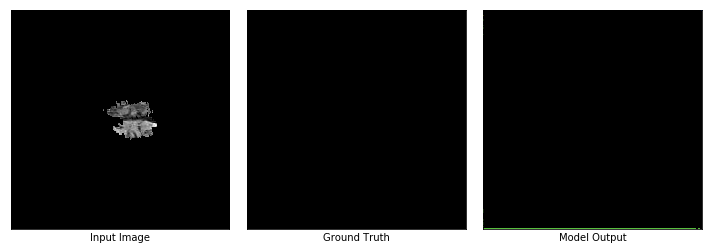

Steps: 137, Loss:0.9986122846603394
Accurary: 0.9955729246139526
Dice coefficient: [3.9525688e-08, 3.9682536e-08, 3.921568e-08]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9956076388896514, 0.9956250000007596, 0.9955729166674353]
Gradient min:-0.00012652201985474676, max:0.00021211009880062193



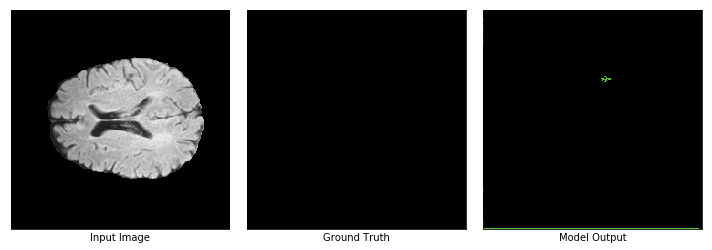

Steps: 138, Loss:0.95053631067276
Accurary: 0.9948611259460449
Dice coefficient: [3.3898303e-08, 3.4013606e-08, 3.3783785e-08]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9948784722231114, 0.9948958333342195, 0.9948611111120033]
Gradient min:-0.004403432831168175, max:0.004343512002378702



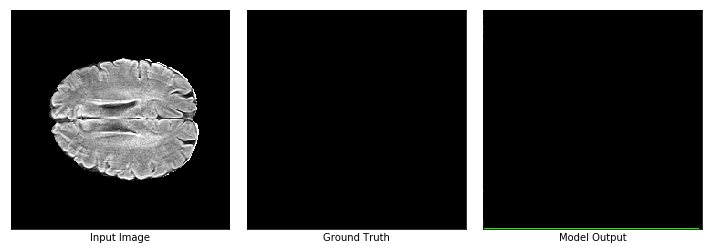

Steps: 139, Loss:0.995410680770874
Accurary: 0.9954166412353516
Dice coefficient: [3.7878788e-08, 3.802281e-08, 3.7878788e-08]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9954166666674624, 0.9954340277785705, 0.9954166666674624]
Gradient min:-0.0009433787199668586, max:0.0005570802604779601



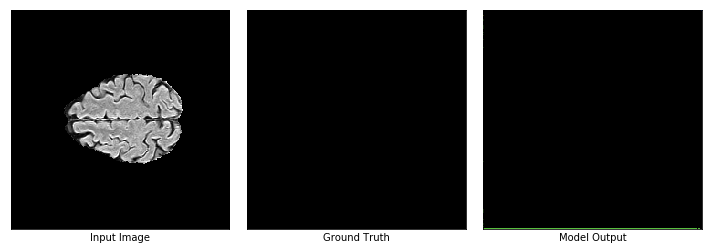

Steps: 140, Loss:0.9582523107528687
Accurary: 0.9955034852027893
Dice coefficient: [3.8910503e-08, 3.90625e-08, 3.8610036e-08]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9955381944452191, 0.9955555555563271, 0.9955034722230028]
Gradient min:-0.008958817459642887, max:0.007523875217884779



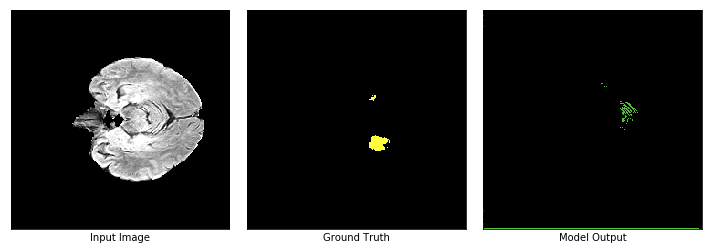

Steps: 141, Loss:0.9653022289276123
Accurary: 0.98828125
Dice coefficient: [2.5510204e-08, 2.5575448e-08, 1.4814814e-08]
Sensitivity: [1.0, 1.0, 3.55871873456517e-08]
Specificity: [0.993194444445626, 0.993211805556734, 0.9931261885250744]
Gradient min:-0.002418061252683401, max:0.00363843678496778



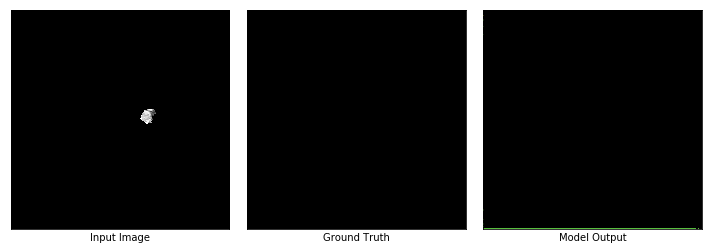

Steps: 142, Loss:0.9668527841567993
Accurary: 0.9957118034362793
Dice coefficient: [4.0816325e-08, 4.0816325e-08, 4.0485826e-08]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9957465277785162, 0.9957465277785162, 0.9957118055563]
Gradient min:-0.0033476618118584156, max:0.0036861971020698547



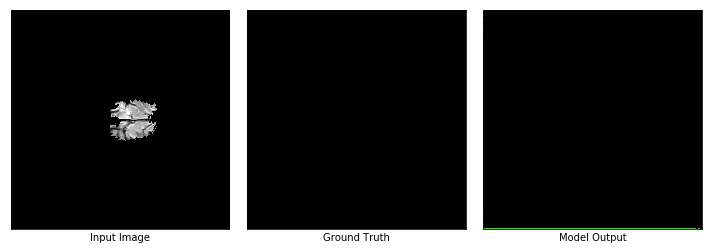

Steps: 143, Loss:0.994685709476471
Accurary: 0.9956770539283752
Dice coefficient: [4.0485826e-08, 4.0485826e-08, 4.016064e-08]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9957118055563, 0.9957118055563, 0.9956770833340839]
Gradient min:-0.00047779662418179214, max:0.0007856883457861841



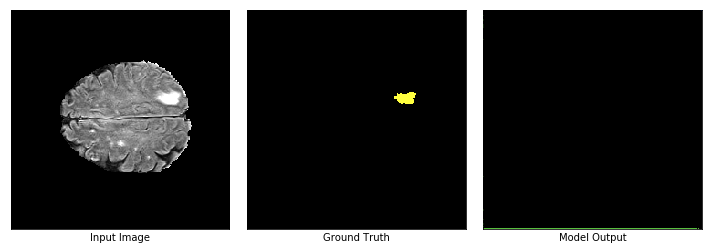

Steps: 144, Loss:0.9263836145401001
Accurary: 0.9916319251060486
Dice coefficient: [3.9682536e-08, 3.9840636e-08, 2.0746887e-08]
Sensitivity: [1.0, 1.0, 4.366812036383754e-08]
Specificity: [0.9956250000007596, 0.9956423611118677, 0.9955901065005682]
Gradient min:-0.005100064445286989, max:0.005355292931199074



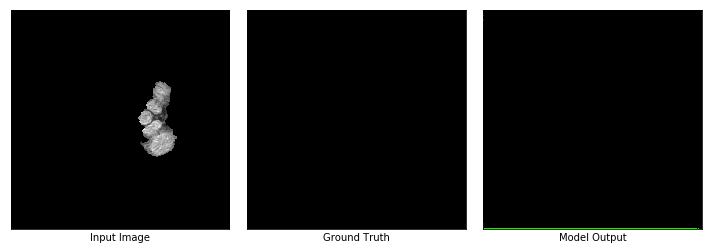

Steps: 145, Loss:0.9860466122627258
Accurary: 0.995763897895813
Dice coefficient: [4.132231e-08, 4.132231e-08, 4.0983604e-08]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9957986111118405, 0.9957986111118405, 0.9957638888896243]
Gradient min:-0.00696278503164649, max:0.006372252479195595



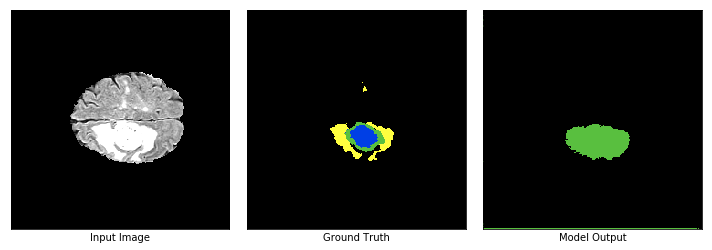

Steps: 146, Loss:0.9409250617027283
Accurary: 0.9629861116409302
Dice coefficient: [0.5551096, 0.27634487, 0.7788602]
Sensitivity: [0.9687500003367456, 0.9305210935354568, 0.8913043484319713]
Specificity: [0.9750846979151813, 0.9661520709187279, 0.9872235960313902]
Gradient min:-0.004432437010109425, max:0.005206359550356865



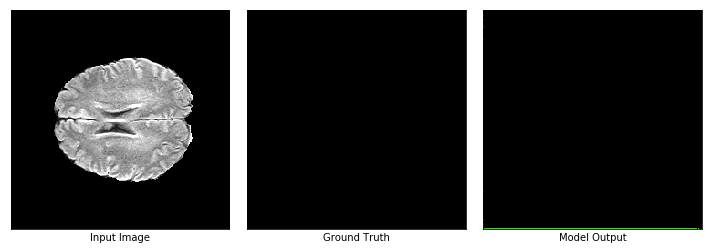

Steps: 147, Loss:0.9622378349304199
Accurary: 0.995642364025116
Dice coefficient: [3.9999996e-08, 4.016064e-08, 3.9840636e-08]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9956597222229757, 0.9956770833340839, 0.9956423611118677]
Gradient min:-0.020053017884492874, max:0.018033014610409737



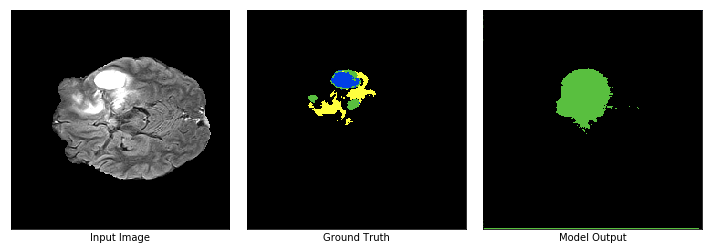

Steps: 148, Loss:0.9560417532920837
Accurary: 0.9494097232818604
Dice coefficient: [0.35654008, 0.16548881, 0.6261019]
Sensitivity: [0.9037433167948754, 0.7960340001123513, 0.90660024964757]
Specificity: [0.9583479912829191, 0.9517529302929842, 0.9716219595007283]
Gradient min:-0.0054345205426216125, max:0.0037306188605725765



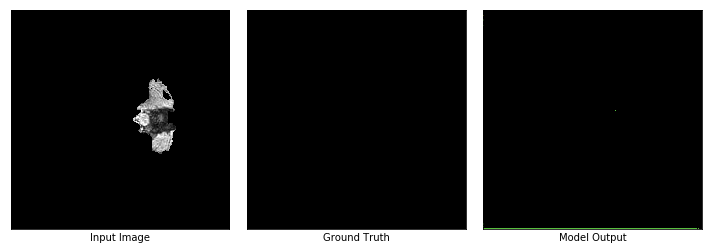

Steps: 149, Loss:0.9607784152030945
Accurary: 0.9957465529441833
Dice coefficient: [4.115226e-08, 4.115226e-08, 4.0816325e-08]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9957812500007325, 0.9957812500007325, 0.9957465277785162]
Gradient min:-0.005112092941999435, max:0.005816991440951824



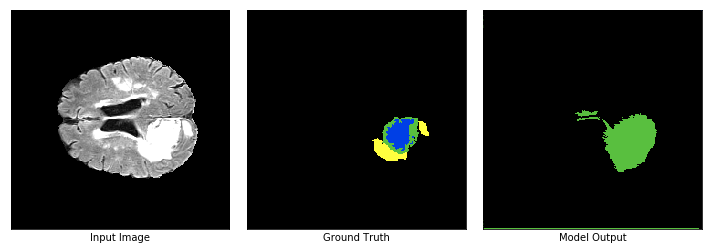

Steps: 150, Loss:0.9758098125457764
Accurary: 0.9551909565925598
Dice coefficient: [0.5749702, 0.29840547, 0.6970206]
Sensitivity: [0.9860997548152105, 0.9685767103775099, 0.9263803685087543]
Specificity: [0.9686751689574339, 0.9571145656325708, 0.9764904044337646]
Gradient min:-0.00748690590262413, max:0.009582353755831718



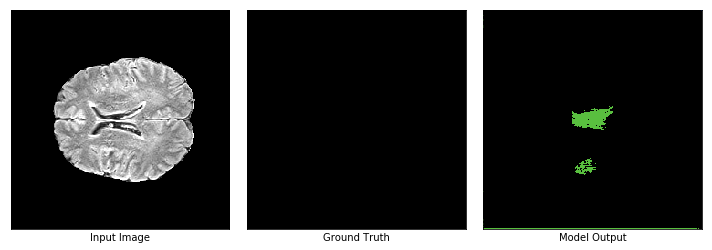

Steps: 151, Loss:0.9284994602203369
Accurary: 0.9806423783302307
Dice coefficient: [8.97666e-09, 8.984726e-09, 8.96861e-09]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.98065972222558, 0.980677083336688, 0.9806423611144718]
Gradient min:-0.011180826462805271, max:0.01121301669627428



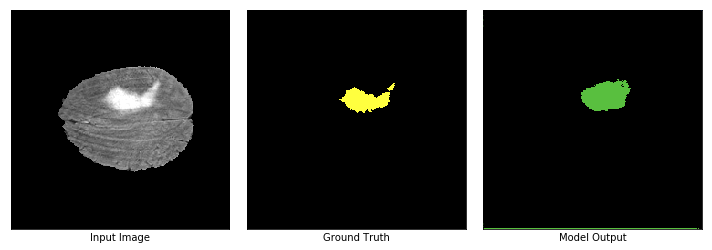

Steps: 152, Loss:0.9543594121932983
Accurary: 0.9702777862548828
Dice coefficient: [6.21118e-09, 6.21504e-09, 0.67132324]
Sensitivity: [1.0, 1.0, 0.8954451356579178]
Specificity: [0.9720486111159637, 0.9720659722270719, 0.9868277006768323]
Gradient min:-0.010334035381674767, max:0.010636712424457073



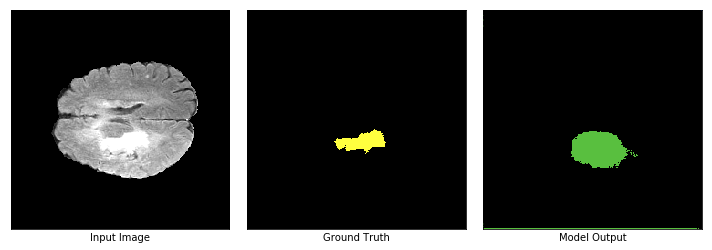

Steps: 153, Loss:0.8903507590293884
Accurary: 0.9606770873069763
Dice coefficient: [4.5330912e-09, 4.5351474e-09, 0.49201065]
Sensitivity: [1.0, 1.0, 0.9272271025442019]
Specificity: [0.9617013888955379, 0.9617187500066461, 0.9741562945664567]
Gradient min:-0.009125812910497189, max:0.007414729800075293



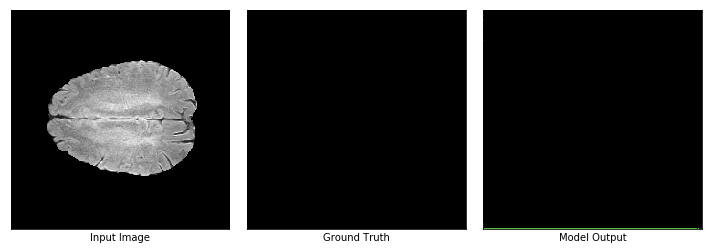

Steps: 154, Loss:0.9793033599853516
Accurary: 0.9957291483879089
Dice coefficient: [4.0816325e-08, 4.0983604e-08, 4.0650402e-08]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9957465277785162, 0.9957638888896243, 0.9957291666674082]
Gradient min:-0.0017956285737454891, max:0.0029149323236197233



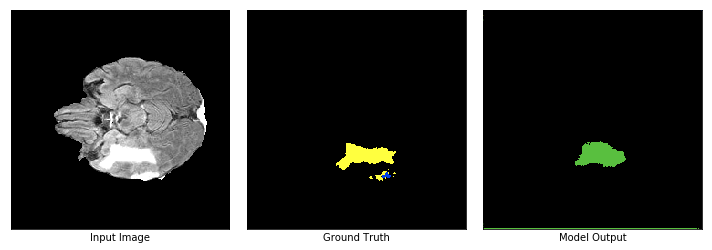

Steps: 155, Loss:0.9574489593505859
Accurary: 0.9723437428474426
Dice coefficient: [7.4850295e-09, 7.722008e-09, 0.69639933]
Sensitivity: [2.4999993750001564e-07, 1.0, 0.7425828992793814]
Specificity: [0.9774843641456767, 0.9775173611150143, 0.9920820491033262]
Gradient min:-0.004662936553359032, max:0.0033268537372350693



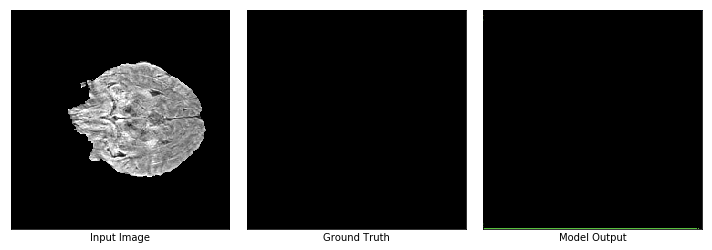

Steps: 156, Loss:0.9584310054779053
Accurary: 0.9957465529441833
Dice coefficient: [4.115226e-08, 4.132231e-08, 4.0816325e-08]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9957812500007325, 0.9957986111118405, 0.9957465277785162]
Gradient min:-0.029976248741149902, max:0.016098937019705772



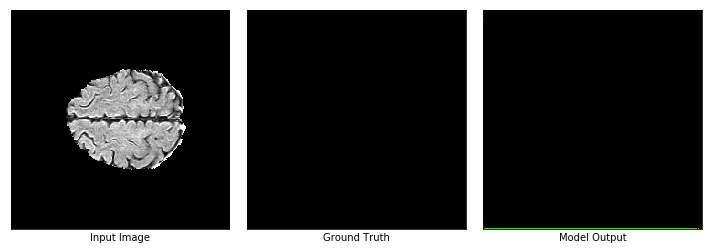

Steps: 157, Loss:0.9476444721221924
Accurary: 0.9957812428474426
Dice coefficient: [4.1493774e-08, 4.1493774e-08, 4.115226e-08]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9958159722229486, 0.9958159722229486, 0.9957812500007325]
Gradient min:-0.023350289091467857, max:0.014948519878089428



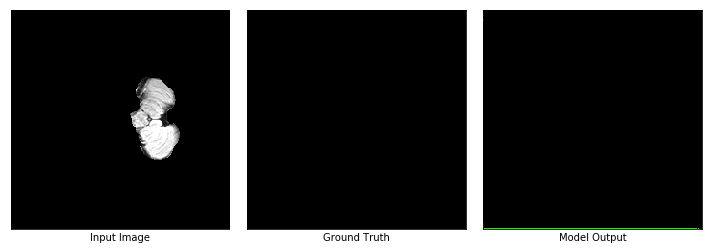

Steps: 158, Loss:0.9873742461204529
Accurary: 0.9957812428474426
Dice coefficient: [4.1493774e-08, 4.1493774e-08, 4.115226e-08]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9958159722229486, 0.9958159722229486, 0.9957812500007325]
Gradient min:-0.0017215104307979345, max:0.0016805264167487621



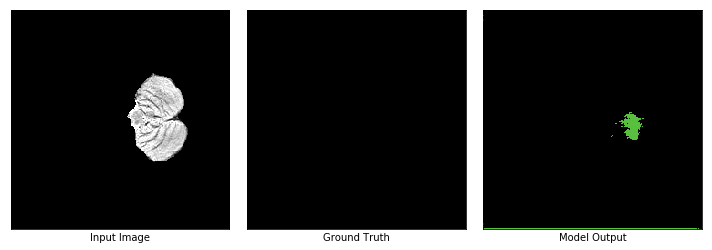

Steps: 159, Loss:0.9342649579048157
Accurary: 0.9885764122009277
Dice coefficient: [1.5243902e-08, 1.5243902e-08, 1.5197568e-08]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9886111111130883, 0.9886111111130883, 0.9885763888908722]
Gradient min:-0.0061370148323476315, max:0.006127898581326008



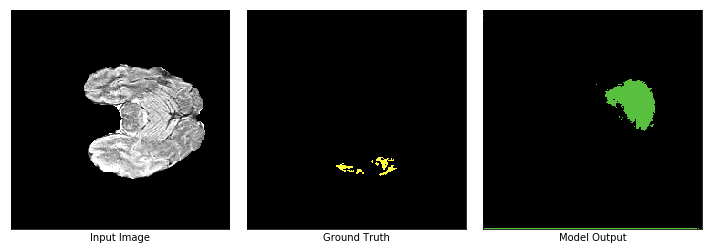

Steps: 160, Loss:0.9273241758346558
Accurary: 0.9588715434074402
Dice coefficient: [4.8520135e-09, 4.854369e-09, 4.22119e-09]
Sensitivity: [1.0, 1.0, 3.267973749412623e-08]
Specificity: [0.964218750006212, 0.9642361111173201, 0.963992739211088]
Gradient min:-0.014321777038276196, max:0.01328507624566555



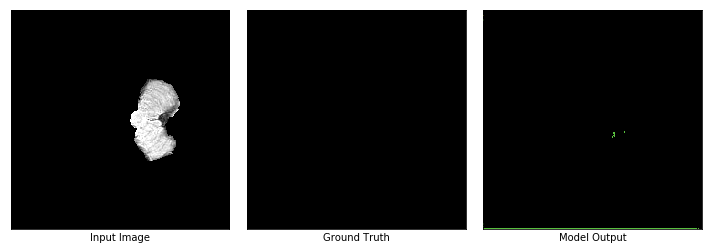

Steps: 161, Loss:0.9416502118110657
Accurary: 0.9955381751060486
Dice coefficient: [3.921568e-08, 3.921568e-08, 3.8910503e-08]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9955729166674353, 0.9955729166674353, 0.9955381944452191]
Gradient min:-0.01733764447271824, max:0.016336794942617416


In [ ]:
epochs = 1
max_epochs = 30
#list
loss_list = []
acc_list = []
loss_inner = []
while epochs <= max_epochs:
    print()
    print("Epochs {:2d}".format(epochs))
    steps = 1
    dc_app = []
    sens_app = []
    spec_app = []
    for tf_re in sorted(os.listdir(tfrecords_read_dir)):
        tf_dir = os.path.join(tfrecords_read_dir+tf_re)
        dataset = utils.parse_tfrecord(tf_dir).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
        acc_inner = []
        for imgs in dataset:
            image = imgs[:,:,:,:4]
            #unprocessed label for plotting 
            label = imgs[:,:,:,-1]
            #for simplicity label 4 will be converted to 3 for sparse encoding
            label = tf.where(label==4,3,label)
            label = tf.keras.utils.to_categorical(label, num_classes=4)
            img_seg, loss, gradients = train_fn(image, label) #training function 
            #map from sparse to label
            img_seg = tf.math.argmax(img_seg,-1,output_type=tf.int32) 
            label = tf.math.argmax(label,-1,output_type=tf.int32)
            #accuracy of the output values for that batch
            acc = tf.reduce_mean(tf.cast(tf.equal(img_seg,label), tf.float32))
            #append accuracy for every steps
            acc_inner.append(acc)
            if epochs%5==0:
                dc_list, sens_list, spec_list =compute_metric(label,img_seg)
                dc_app.append(dc_list)
                sens_app.append(sens_list)
                spec_app.append(spec_list)
            #output
            if steps%1000==0:
                input_img = [image[0,:,:,0], plot_labels_color(label[0]), plot_labels_color(img_seg[0])]
                caption = ['Input Image', 'Ground Truth', 'Model Output']
                plot_comparison(input_img, caption, n_col = 3, figsize=(10,10))
                loss_list.append(loss)
                acc_stp = tf.reduce_mean(tf.cast(tf.equal(img_seg[0],label[0]), tf.float32))
                dc_list_stp, sens_list_stp, spec_list_stp =compute_metric(label[0],img_seg[0])
                print("Steps: {}, Loss:{}".format(steps, loss))
                print("Accurary: {}".format(acc_stp))
                print("Dice coefficient: {}".format(dc_list_stp))
                print("Sensitivity: {}".format(sens_list_stp))
                print("Specificity: {}".format(spec_list_stp))
                print("Gradient min:{}, max:{}".format(np.min(gradients[0]), np.max(gradients[0])))
            steps+=1
        acc_list.append(np.mean(acc_inner))
    if epochs%5==0:
        mean_dc = np.mean(np.array(dc_app),0)
        mean_sens = np.mean(np.array(sens_app),0)
        mean_spec = np.mean(np.array(spec_app),0)
        print()
        print('-----------<Summary for Epoch:{}>------------'.format(epochs))
        print("Mean Accuracy: {}".format(np.mean(acc_list)))
        print("Mean Dice coefficient: {}".format(mean_dc))
        print("Mean Sensitivity: {}".format(mean_sens))
        print("Mean Specificity: {}".format(mean_spec))
        print('------------------------------------------------')
        print()
    epochs+=1 

---

# Save Weights

In [ ]:
model.save_weights('/home/kevinteng/Desktop/model_weights/model_{}.h5'.format(ver))

---

# Validation 

In [ ]:
model.load_weights('/home/kevinteng/Desktop/model_weights/model_{}.h5'.format(ver))
def val_fn(image, label):
    model.trainable = False
    model_output = model(image)
    loss = xent(label, model_output)
    return model_output, loss

In [ ]:
tfrecords_val = '/home/kevinteng/Desktop/ssd02/BraTS20_tfrecords03/LGG/'

steps = 1
acc_list = []
for tf_re in sorted(os.listdir(tfrecords_val)):
    tf_dir = os.path.join(tfrecords_val+tf_re)
    dataset = utils.parse_tfrecord(tf_dir).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
    dc_app = []
    sens_app = []
    spec_app = []
    for imgs in dataset:
        image = imgs[:,:,:,:4]
        label = imgs[:,:,:,-1]
        label = tf.where(label==4,3,label)
        #for simplicity label 4 will be converted to 3 for sparse encoding
        label = tf.keras.utils.to_categorical(label, num_classes=4)
        img_seg, loss = val_fn(image, label) #validation function 
        #map from sparse to label
        img_seg = tf.math.argmax(img_seg,-1,output_type=tf.int32) 
        label = tf.math.argmax(label,-1,output_type=tf.int32)
        #accuracy of the output values for that batch
        acc = tf.reduce_mean(tf.cast(tf.equal(img_seg,label), tf.float32))
        dc_list, sens_list, spec_list =compute_metric(label,img_seg)
        #append
        acc_list.append(acc)
        dc_app.append(dc_list)
        sens_app.append(sens_list)
        spec_app.append(spec_list)
        #output
        if steps%100==0:
#             dc_list, sens_list, spec_list =compute_metric(label[0],img_seg[0])
            input_img = [image[0,:,:,0], plot_labels_color(label[0]), plot_labels_color(img_seg[0])]
            caption = ['Input Image', 'Ground Truth', 'Model Output']
            plot_comparison(input_img, caption, n_col = 3, figsize=(10,10))
            acc_stp = tf.reduce_mean(tf.cast(tf.equal(img_seg[0],label[0]), tf.float32))
            dc_list, sens_list, spec_list =compute_metric(label[0],img_seg[0])
            print("Steps: {}, Loss:{}".format(steps, loss))
            print("Accuracy: {}".format(acc_stp))
            print("Dice coefficient: {}".format(dc_list))
            print("Sensitivity: {}".format(sens_list))
            print("Specificity: {}".format(spec_list))
        steps+=1
    mean_dc = np.mean(np.array(dc_app),0)
    mean_sens = np.mean(np.array(sens_app),0)
    mean_spec = np.mean(np.array(spec_app),0)
    print("Mean Accuracy: {}".format(np.mean(acc_list)))
    print("Mean Dice coefficient: {}".format(mean_dc))
    print("Mean Sensitivity: {}".format(mean_sens))
    print("Mean Specificity: {}".format(mean_spec))

---

# Model Summary

In [ ]:
model.summary()